In [1]:
# libraries and dataset imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

daily_df = pd.read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv') # df containing all daily activity data for each user
weight_log = pd.read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv') # records of users weight logs
sleep_log = pd.read_csv('/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv') # records of users sleep logs

# Introduction

I recently decided to complete the Google Data Analytics certification to provide evidence of my data analysis skills and to check my data analysis knowledge. <br>
The final course in the certification is performing your own case study. We were provided 2 topics to choose from or you can find your own. I chose the Bellabeat case study. <br>
<br>
Bellabeat is a women's wellness company. They develop wearable fitness trackers for women as well as other health-focused products, including an app and a water bottle that tracks your water intake. <br>
The purpose of this case study is to leverage smart device user data to influence Bellabeat's marketing strategy. As the junior data analyst in the scenario, my job is to analyze the provided Fitbit dataset and deliver the insights derived to the executive team which will then be used to influence our marketing strategy. <br>
Bellabeat has multiple products, so we were asked to focus on just one for the case study. After examining the data, I chose one of their wearable wellness trackers, Time. I will explain my choice in the final section. <br>
<br>
The data provided contained a few datasets but the ones I chose to work with are the daily activity dataset, weight log and sleep log. I think these will provide the most valuable usage trends. <br>
I do feel that there are aspects that this data is lacking that would provide more insight into the motivation behind wearing fitness trackers, who the customer base is and what they like/don't like about their current devices. So, I spent some time looking for supplementary data and I was able to find a paper called "Users' Experience of Wearable Activity Trackers" published in BMC Public Health.<sup>[4]</sup> My intention is to use the data from this study to back up or supplement my findings in the analysis. The reason I chose this paper, aside from the fact that there are almost no other similar studies that are open access, was that it focused on feedback from current and ex-users. This has a ton of value for this case study. <br> 
<br>
Aside from the data processing and analyzing performed in this notebook, I also filled out the Case Study Roadmap to ensure each part was fully addressed and flesh out my thought process. My copy can be found at the link below: <br>
https://drive.google.com/file/d/1w-IhhZNlm1AWVvPnIs9fMzYHAlKom5m4/view?usp=sharing


# Preparing and Processing the Data

Before I get into the analysis, I will take some time to get a better understanding of each dataset and check for any possible errors or problematic records.

## Examining the Daily Activity Dataset

In [2]:
daily_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [3]:
daily_df.shape

(940, 15)

In [4]:
# checking the datatype of each column

daily_df.dtypes

Id                            int64
ActivityDate                 object
TotalSteps                    int64
TotalDistance               float64
TrackerDistance             float64
LoggedActivitiesDistance    float64
VeryActiveDistance          float64
ModeratelyActiveDistance    float64
LightActiveDistance         float64
SedentaryActiveDistance     float64
VeryActiveMinutes             int64
FairlyActiveMinutes           int64
LightlyActiveMinutes          int64
SedentaryMinutes              int64
Calories                      int64
dtype: object

In [5]:
# Reformat dates to datetime

daily_df['ActivityDate'] = pd.to_datetime(daily_df['ActivityDate'])

daily_df.dtypes

Id                                   int64
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
dtype: object

In [6]:
# Number of users, number of days and study period

users = daily_df['Id'].nunique()
days = daily_df['ActivityDate'].nunique()
min_date = daily_df['ActivityDate'].min().date()
max_date = daily_df['ActivityDate'].max().date()

print("There were", users, "users recorded for", days, "days from", min_date, "to", max_date)

There were 33 users recorded for 31 days from 2016-04-12 to 2016-05-12


In [7]:
# Frequency of records and checking for duplicates

every_day = daily_df['Id'].value_counts().loc[lambda x : x == 31].count() # count of Ids with 31 records (value_counts returns number of records per user, loc and lambda filter for desired number)
missed_days = daily_df['Id'].value_counts().loc[lambda x : x < 31].count() # count of Ids with less than 31 records
min_records = daily_df['Id'].value_counts().min()
dup_count = daily_df.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers who missed some days:', missed_days, '\nMinimum number of records:', daily_df['Id'].value_counts().min(), '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 21 
Users who missed some days: 12 
Minimum number of records: 4 
Duplicate records: 0


In [8]:
# Looking for null values

for col in daily_df.columns.values:
    if (daily_df.loc[daily_df[col].isnull() == True]).empty: # if there are no nulls in the current column it will go to the next column
        pass
    else:
        print(col, ':', daily_df[col].isnull().sum(), 'Nulls') # prints column name and count of nulls

There are no null values in the dataset.

### Deciphering the Relationship Between Distance Fields 
I wanted to confirm my thinking that the total distance field was the sum of logged activities distance and tracker distance but quickly found that that was not the case.

In [9]:
# Count of records where total distance is not equal to tracker distance + logged activities distance

print("Records where total distance not equal to tracker distance + logged activities distance:",daily_df['LoggedActivitiesDistance'].loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'] + daily_df['LoggedActivitiesDistance'])].count())

# Count of activity distances greater than 0

print("Records where logged activities distance greater than zero:",daily_df['LoggedActivitiesDistance'].loc[daily_df['LoggedActivitiesDistance'] > 0].count())

Records where total distance not equal to tracker distance + logged activities distance: 32
Records where logged activities distance greater than zero: 32


In [10]:
# Check if the two subsets overlap

daily_df.loc[daily_df['LoggedActivitiesDistance'] > 0].equals(daily_df.loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'] + daily_df['LoggedActivitiesDistance'])])

True

All records with a logged activities distances greater than zero coincide with records where total distance isn't the sum of tracker distance and logged activities distance.

In [11]:
# Records where total distance is not equal to tracker distance

print("Record count:",daily_df['LoggedActivitiesDistance'].loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'])].count())
daily_df.loc[daily_df['TotalDistance'] != (daily_df['TrackerDistance'])]

Record count: 15


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
689,6962181067,2016-04-21,11835,9.71,7.88,4.081692,3.99,2.10,3.51,0.11,53,27,214,708,2179
693,6962181067,2016-04-25,13239,9.27,9.08,2.785175,3.02,1.68,4.46,0.10,35,31,282,637,2194
707,6962181067,2016-05-09,12342,8.72,8.68,3.167822,3.90,1.18,3.65,0.00,43,21,231,607,2105
711,7007744171,2016-04-12,14172,10.29,9.48,4.869783,4.50,0.38,5.41,0.00,53,8,355,1024,2937
712,7007744171,2016-04-13,12862,9.65,8.60,4.851307,4.61,0.56,4.48,0.00,56,22,261,1101,2742
713,7007744171,2016-04-14,11179,8.24,7.48,3.285415,2.95,0.34,4.96,0.00,34,6,304,1096,2668
717,7007744171,2016-04-18,14816,10.98,9.91,4.930550,3.79,2.12,5.05,0.02,48,31,284,1077,2832
718,7007744171,2016-04-19,14194,10.48,9.50,4.942142,4.41,0.76,5.31,0.00,53,17,304,1066,2812
719,7007744171,2016-04-20,15566,11.31,10.41,4.924841,4.79,0.67,5.86,0.00,60,33,347,1000,3096
724,7007744171,2016-04-25,18229,13.34,12.20,4.861792,4.31,1.37,7.67,0.00,51,24,379,986,3055


In [12]:
# Records where total distance is equal to trackerdistance but the loggedactivities distance is > 0 

print("Record count:",daily_df['LoggedActivitiesDistance'].loc[(daily_df['TotalDistance'] == (daily_df['TrackerDistance'])) & (daily_df['LoggedActivitiesDistance'] > 0)].count())
daily_df.loc[(daily_df['TotalDistance'] == (daily_df['TrackerDistance'])) & (daily_df['LoggedActivitiesDistance'] > 0)]

Record count: 17


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
668,6775888955,2016-04-26,7091,5.27,5.27,1.959596,3.48,0.87,0.73,0.0,42,30,47,1321,2584
818,8378563200,2016-04-12,7626,6.05,6.05,2.253081,0.83,0.71,4.50,0.0,65,15,156,723,3635
819,8378563200,2016-04-13,12386,9.82,9.82,2.092147,4.96,0.65,4.21,0.0,116,14,169,680,4079
820,8378563200,2016-04-14,13318,10.56,10.56,2.253081,5.62,1.03,3.91,0.0,123,21,174,699,4163
824,8378563200,2016-04-18,13630,10.81,10.81,2.092147,5.05,0.56,5.20,0.0,117,10,174,720,4157
825,8378563200,2016-04-19,13070,10.36,10.36,2.253081,5.30,0.88,4.18,0.0,120,19,154,737,4092
826,8378563200,2016-04-20,9388,7.44,7.44,2.092147,2.23,0.44,4.78,0.0,82,8,169,763,3787
827,8378563200,2016-04-21,15148,12.01,12.01,2.253081,6.90,0.82,4.29,0.0,137,16,145,677,4236
828,8378563200,2016-04-22,12200,9.67,9.67,2.092147,4.91,0.59,4.18,0.0,113,12,159,769,4044
831,8378563200,2016-04-25,12405,9.84,9.84,2.092147,5.05,0.87,3.92,0.0,117,16,141,692,4005


Clearly the total distance is not calculated by adding the two together. Without knowing how Fitbit handles this data, I cannot decipher the relationship. <br>
Because of this, I will only use the total distance moving forward.

### Looking for Outliers

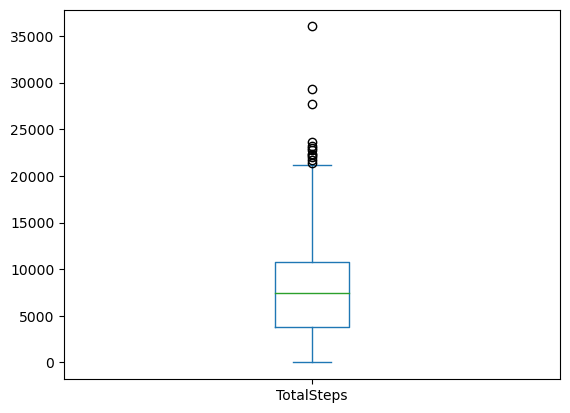

In [13]:
# Total steps boxplot

_ = daily_df.plot(y = 'TotalSteps', kind = 'box')

In [14]:
# Maximum steps

daily_df.loc[daily_df['TotalSteps'] == daily_df['TotalSteps'].max()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
50,1624580081,2016-05-01,36019,28.030001,28.030001,0.0,21.92,4.19,1.91,0.02,186,63,171,1020,2690


In [15]:
# Maximum total distance

daily_df.loc[daily_df['TotalDistance'] == daily_df['TotalDistance'].max()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
50,1624580081,2016-05-01,36019,28.030001,28.030001,0.0,21.92,4.19,1.91,0.02,186,63,171,1020,2690


The record with the most total steps is also the record with the highest total distance. This indicates to me that the record is accurate and should be kept. While it is a lot of steps, it is not completely outrageous either.

In [16]:
# Minimum steps

daily_df.loc[daily_df['TotalSteps'] == daily_df['TotalSteps'].min()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
30,1503960366,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
104,1844505072,2016-04-24,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347
105,1844505072,2016-04-25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347
106,1844505072,2016-04-26,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1347
112,1844505072,2016-05-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,8792009665,2016-05-06,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1688
905,8792009665,2016-05-07,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1688
906,8792009665,2016-05-08,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1688
907,8792009665,2016-05-09,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,1688


Likely due to the device not being worn. No concerning minimums ie. negatives.

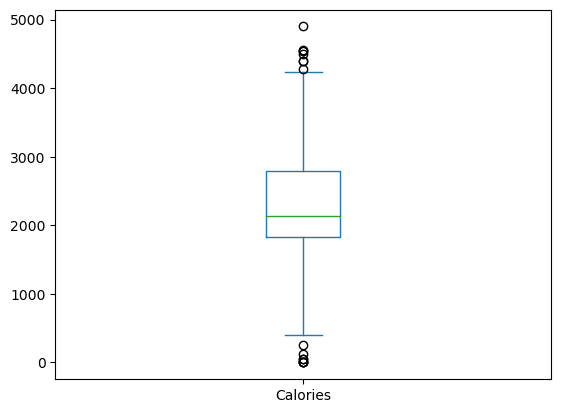

In [17]:
# Calories boxplot

_ = daily_df.plot(y = 'Calories', kind = 'box')

In [18]:
# Maximum calories burned

daily_df.loc[daily_df['Calories'] == daily_df['Calories'].max()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
606,6117666160,2016-04-21,19542,15.01,15.01,0.0,0.98,0.4,5.62,0.0,11,19,294,579,4900


The record with the most calories burned, while high, is well within the range of normal. 

In [19]:
# Minimum calories

daily_df.loc[daily_df['Calories'] == daily_df['Calories'].min()]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
30,1503960366,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
653,6290855005,2016-05-10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
817,8253242879,2016-04-30,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0
879,8583815059,2016-05-12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1440,0


Clearly, these are times when the device was not worn for the whole day. No concerning minimums ie. negatives.

In [20]:
# Looking for any active minute records with values greater than 24 hours

minutes = ['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']

for i in minutes:
    if daily_df.loc[daily_df[i] > 1440].empty: # if the current column does not have any records higher than 1440 min it moves to the next one
        pass
    else:
        print(i, ':', (daily_df[i] > 1440).sum(), 'active minute records greater than 24hrs') # prints the column name and a count of records higher than 1440 min

In [21]:
# Looking for records where the sum of all active minute fields is greater than 24 hours

minute_sum = daily_df.copy() # Create a copy of daily_df

minute_sum['ActiveMinSum'] = minute_sum[minutes].sum(axis=1) # Create a column that is the sum of all active minute columns per row

minute_sum.loc[minute_sum['ActiveMinSum'] > 1440]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,ActiveMinSum


There are no records with active minutes greater than 24 hours.

In [22]:
# Looking for any active distance records greater than total distance

dist_cols = ['VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance']

for i in dist_cols:
    if daily_df.loc[daily_df[i] > daily_df['TotalDistance']].empty: # if the current column does not have any records where the value is higher than the total distance it moves to the next one
        pass
    else:
        print(i, ':', (daily_df[i] > daily_df['TotalDistance']).sum(), 'active distance records greater than total distance') # prints the column name and count of records higher than the total distance

In [23]:
# Looking for records where the sum of all active distance fields is greater than total distance
# Originally, my plan was to display any rows where the sum was greater than the total distance but due to rounding issues, there were actually quite a few but none were significant so I created the difference field and displayed those with a difference greater than 0.015

distance_sum = daily_df.copy() # Create a copy of daily_df

distance_sum['ActiveDistSum'] = distance_sum[dist_cols].sum(axis=1) # Create a column that is the sum of all active distance columns per row

distance_sum['DistDiff'] = distance_sum['ActiveDistSum'] - distance_sum['TotalDistance'] # Calculate the difference between the 2 columns

distance_sum.loc[distance_sum['DistDiff'] > 0.015]

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,ActiveDistSum,DistDiff


There are no records with active distances greater than the total distance.

## Examining the Sleep Log Dataset

In [24]:
sleep_log.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


In [25]:
sleep_log.shape

(413, 5)

In [26]:
sleep_log.dtypes

Id                     int64
SleepDay              object
TotalSleepRecords      int64
TotalMinutesAsleep     int64
TotalTimeInBed         int64
dtype: object

In [27]:
# Reformat dates to datetime

sleep_log['SleepDay'] = pd.to_datetime(sleep_log['SleepDay'])

sleep_log.dtypes

Id                             int64
SleepDay              datetime64[ns]
TotalSleepRecords              int64
TotalMinutesAsleep             int64
TotalTimeInBed                 int64
dtype: object

In [28]:
# Record frequency and checking for duplicate records

every_day = sleep_log['Id'].value_counts().loc[lambda x : x >= 31].count() # count of Ids with 31 records (or more because one of the users with duplicate records has 32 records)
missed_days = sleep_log['Id'].value_counts().loc[lambda x : x < 31].count() # count of Ids with less than 31 records
sleep_users = every_day + missed_days
dup_count = sleep_log.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers with records for some of the days:', missed_days, '\nUsers who did not record their sleep at all:', users - sleep_users, '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 3 
Users with records for some of the days: 21 
Users who did not record their sleep at all: 9 
Duplicate records: 3


There are 3 duplicate records. I will look at and remove them.

In [29]:
sleep_log.loc[sleep_log.duplicated() == True]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
161,4388161847,2016-05-05,1,471,495
223,4702921684,2016-05-07,1,520,543
380,8378563200,2016-04-25,1,388,402


In [30]:
sleep_log = sleep_log.drop_duplicates()

# run the frequency/duplicate check again 

every_day = sleep_log['Id'].value_counts().loc[lambda x : x == 31].count()
missed_days = sleep_log['Id'].value_counts().loc[lambda x : x < 31].count()
dup_count = sleep_log.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers with records for some of the days:', missed_days, '\nUsers who did not record their sleep at all:', users - (every_day + missed_days), '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 3 
Users with records for some of the days: 21 
Users who did not record their sleep at all: 9 
Duplicate records: 0


In [31]:
# Looking for null values

for col in sleep_log.columns.values:
    if (sleep_log.loc[sleep_log[col].isnull() == True]).empty:
        pass
    else:
        print(col, ':', sleep_log[col].isnull().sum(), 'Nulls')

There are no null values in the dataset.

### Looking for Outliers

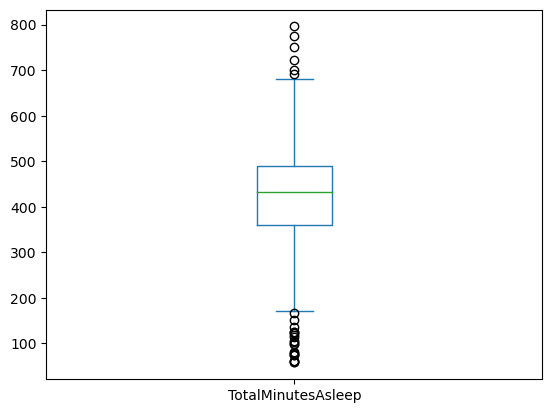

In [32]:
_ = sleep_log.plot(y = 'TotalMinutesAsleep', kind = 'box')

In [33]:
sleep_log.loc[sleep_log['TotalMinutesAsleep'] == sleep_log['TotalMinutesAsleep'].max()]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
27,1644430081,2016-05-02,1,796,961


Most time spent asleep is 13 hours, quite high but not outside the possible range.

In [34]:
sleep_log.loc[sleep_log['TotalMinutesAsleep'] == sleep_log['TotalMinutesAsleep'].min()]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
338,7007744171,2016-05-01,1,58,61


Least amount of time spent asleep is just under an hour. Extremely low but there are many factors as to why it might be so low. For example, their watch could have died or they recorded a nap and not their overnight sleep.

In [35]:
# Looking for records where total time in bed is less than total minutes asleep (should not be possible)

sleep_log.loc[sleep_log['TotalMinutesAsleep'] > sleep_log['TotalTimeInBed']]

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed


## Examining the Weight Log Dataset

In [36]:
weight_log.head()

,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,True,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,True,1463097599000


In [37]:
weight_log.shape

(67, 8)

In [38]:
weight_log.dtypes

Id                  int64
Date               object
WeightKg          float64
WeightPounds      float64
Fat               float64
BMI               float64
IsManualReport       bool
LogId               int64
dtype: object

In [39]:
# The date field also has time, if there are multiple time stamps on one date there will be multiples of that date
# Count of unique dates

weight_log['Date'].nunique()

56

In [40]:
# Reformat dates as datetime and remove the time portion

weight_log['Date'] = pd.to_datetime(weight_log['Date']).dt.date

weight_log.dtypes

Id                  int64
Date               object
WeightKg          float64
WeightPounds      float64
Fat               float64
BMI               float64
IsManualReport       bool
LogId               int64
dtype: object

In [41]:
# Count of unique dates after removing the timestamp
# The study period was 31 days, this lines up 

weight_log['Date'].nunique()

31

In [42]:
# Record frequency and checking for duplicates

every_day = weight_log['Id'].value_counts().loc[lambda x : x == 31].count() # count of Ids with 31 records
missed_days = weight_log['Id'].value_counts().loc[lambda x : x < 31].count() # count of Ids with 31 records
max_records = weight_log['Id'].value_counts().max()
weight_users = every_day + missed_days
dup_count = weight_log.duplicated().sum()

print('Users with records for each day of the survey period:', every_day, '\nUsers with records for some of the days:', missed_days, '\nHighest number of records:', max_records, '\nUsers who did not record their weight at all:', users - weight_users, '\nDuplicate records:', dup_count)

Users with records for each day of the survey period: 0 
Users with records for some of the days: 8 
Highest number of records: 30 
Users who did not record their weight at all: 25 
Duplicate records: 0


In [43]:
# Looking for null values

for col in weight_log.columns.values:
    if (weight_log.loc[weight_log[col].isnull() == True]).empty:
        pass
    else:
        print(col, ':', weight_log[col].isnull().sum(), 'Nulls')

Fat : 65 Nulls


65 out of 67 records are null for this column. I will remove the Fat column.

In [44]:
# Removing the Fat column

weight_log = weight_log.drop('Fat', axis=1)

weight_log.head()

,Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
0,1503960366,2016-05-02,52.599998,115.963147,22.650000,True,1462233599000
1,1503960366,2016-05-03,52.599998,115.963147,22.650000,True,1462319999000
2,1927972279,2016-04-13,133.500000,294.317120,47.540001,False,1460509732000
3,2873212765,2016-04-21,56.700001,125.002104,21.450001,True,1461283199000
4,2873212765,2016-05-12,57.299999,126.324875,21.690001,True,1463097599000


I wanted to check conversion between Kg and Lb but the conversion requires too many decimals to be accurate easily. Unable to properly compare.

# Analysis

In the analysis, I will be looking for trends in the data and comparing the record values against daily recommended values, such as the daily recommended number of steps or hours of sleep. As well as other potentially informative trends such as the most active days of the week.

## Daily Activity Analysis

In [45]:
daily_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


### Finding the Most Active Day(s) of the Week

In [46]:
# Adding columns for the day of the week (num) and week number so each week can be identified

daily_df['dayofweek'] = daily_df['ActivityDate'].dt.weekday
daily_df['weeknum'] = daily_df['ActivityDate'].dt.isocalendar().week

daily_df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,dayofweek,weeknum
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,1,15
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,2,15
2,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,3,15
3,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,4,15
4,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,5,15


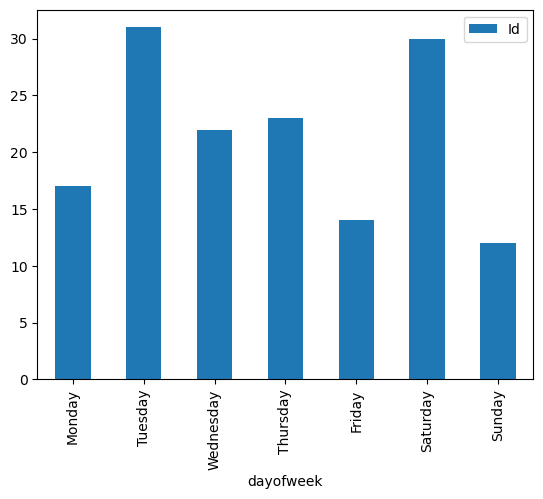

In [47]:
# Get max steps per week, find day of week
# Plot frequency of each day being the max to show which days people are most active

rm_zeros = daily_df.query("TotalSteps > 0") # remove rows where total steps are 0

max_steps_msk = rm_zeros.groupby(['Id','weeknum'])['TotalSteps'].transform('max') == rm_zeros['TotalSteps'] # Boolean mask that tells me which rows are the max steps for each user per week, I can use this to filter the df and find which day of the week that is - borrowed from [5]
max_steps = rm_zeros.loc[max_steps_msk, ['Id','dayofweek']] # Find day of the week for each max
    
max_count = max_steps.groupby(['dayofweek']).count() # Count frequency of each day
_ = max_count.plot(kind='bar').set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']) # Create the bar plot and change x axis tick labels to the days of the week

### Daily Step Recommendation
The recommended number of steps per day is 10,000 and less than 5,000 steps per day is considered sedentary.<sup>[3]</sup>

In [48]:
# User counts for 7 average total steps bins and calculate % of total users
# I chose 7 bins because I wanted to be able to get a bin close to 5000 steps and one close to 10000 steps, this table will be used for visualizations in my deliverable

avg_steps_cals = daily_df[['Id', 'TotalSteps', 'Calories']]

avg_steps_cals = avg_steps_cals.groupby('Id').mean() # Average total steps and calories per user

avg_steps = pd.DataFrame(data=(avg_steps_cals['TotalSteps'].value_counts(bins=7, sort=False)))

avg_steps.rename(columns={'TotalSteps': 'User_Count'}, inplace=True)

avg_steps['%_of_Total_Users'] = round((avg_steps['User_Count']/users) * 100,1)

avg_steps

,User_Count,%_of_Total_Users
"(901.004, 3076.687]",5,15.2
"(3076.687, 5237.244]",3,9.1
"(5237.244, 7397.802]",9,27.3
"(7397.802, 9558.359]",8,24.2
"(9558.359, 11718.917]",5,15.2
"(11718.917, 13879.475]",1,3.0
"(13879.475, 16040.032]",2,6.1


In [49]:
# Add column for if they met the step goal that day

step_goal = daily_df.copy()

step_goal['Goal'] = np.where(step_goal['TotalSteps'] >= 10000, 1, 0) # 1 for if the goal is met and 0 otherwise

goal_sum = step_goal[['Id','Goal']].groupby('Id').sum() # Find the number of times each user met the goal

goal_sum['Percent'] = round(goal_sum['Goal']/days * 100,2) # Percent of times the goal was met over the total number of days

goal_percent = pd.DataFrame(data=(goal_sum['Percent'].value_counts(bins=[0,25,50,75,100], sort=False)))

goal_percent.rename(columns={'Percent': 'User_Count'}, inplace=True)

goal_percent['%_of_Total_Users'] = round((goal_percent['User_Count']/users) * 100,1)

goal_percent

,User_Count,%_of_Total_Users
"(-0.001, 25.0]",19,57.6
"(25.0, 50.0]",5,15.2
"(50.0, 75.0]",5,15.2
"(75.0, 100.0]",4,12.1


### Daily Exercise Recommendation
The CDC recommends 30 minutes of moderate exercise a day (5 times a week).<sup>[1]</sup> How many of the users have an average active minutes of 30 minutes or more? <br>
I used both the Very Active and Fairly Active Minutes fields to make this determination.

In [50]:
# Get an average of each level of active minutes and calculate a new field called exercise minutes, which is the sum of average very active minutes and fairly active minutes

active_min = daily_df.copy()

active_min['exercise_min'] = active_min['VeryActiveMinutes'] + active_min['FairlyActiveMinutes']

avg_active_min = active_min[['Id', 'exercise_min']].groupby('Id').mean()

In [51]:
# User counts for 4 exercise minute bins and calculate percent of total users

daily_exercise_min = pd.DataFrame(data=(avg_active_min['exercise_min'].value_counts(bins=4, sort=False)))

daily_exercise_min.rename(columns={'exercise_min': 'User_Count'}, inplace=True)

daily_exercise_min['%_of_Total_Users'] = round((daily_exercise_min['User_Count']/users) * 100,1)

daily_exercise_min

,User_Count,%_of_Total_Users
"(0.237, 29.558]",16,48.5
"(29.558, 58.761]",11,33.3
"(58.761, 87.964]",4,12.1
"(87.964, 117.167]",2,6.1


In [52]:
# Add column for if they met the exercise goal that day

exer_goal = active_min.copy()

exer_goal['Goal'] = np.where(active_min['exercise_min'] >= 30, 1, 0) # 1 for if the goal is met and 0 otherwise

e_goal_sum = exer_goal[['Id','Goal']].groupby('Id').sum() # Find the number of times each user met the goal

e_goal_sum['Percent'] = round(e_goal_sum['Goal']/days * 100,2) # Percent of times the goal was met over the total number of days

e_goal_percent = pd.DataFrame(data=(e_goal_sum['Percent'].value_counts(bins=[0,25,50,75,100], sort=False)))

e_goal_percent.rename(columns={'Percent': 'User_Count'}, inplace=True)

e_goal_percent['%_of_Total_Users'] = round((e_goal_percent['User_Count']/users) * 100,1)

e_goal_percent

,User_Count,%_of_Total_Users
"(-0.001, 25.0]",13,39.4
"(25.0, 50.0]",8,24.2
"(50.0, 75.0]",5,15.2
"(75.0, 100.0]",7,21.2


In [53]:
# Count of times they met the goal each week and find users who met the goal at least 5 times in a week

weekly_exer_goal = exer_goal[['Id', 'weeknum', 'Goal']].groupby(['Id','weeknum']).sum()

weekly_exer_goal['WeekGoal'] = np.where(weekly_exer_goal['Goal'] >= 5, 1, 0) # Create new column for whether they met the goal 5 times that week or not

drop = weekly_exer_goal.droplevel(level='weeknum') # drop the weeknum column so we can groupby just the Id

week_goal_sum = drop[['WeekGoal']].groupby(drop.index).sum() # get a sum of the times they met the weekly goal, there were 5 weeks but the 5th only had 4 days so no one would be able to meet the goal that week

week_goal = pd.DataFrame(data=week_goal_sum.value_counts(sort=False))

week_goal.rename(columns={0: 'User_Count'}, inplace=True) # rename column

week_goal.index.names = ['NumofWeeks'] # rename index

week_goal['%_Total_of_Users'] = round((week_goal['User_Count']/users) * 100,1)

week_goal

,User_Count,%_Total_of_Users
NumofWeeks,,
0,18,54.5
1,4,12.1
2,5,15.2
3,1,3.0
4,5,15.2


### Calorie Recommendation

Based on a variety of resources, I decided to split the calories into less than 2000 and more than 2000, less than 2000 indicating a more sedentary lifestyle and more than 2000 indicating a more active lifestyle.

In [54]:
# Count of users burning less than the recommended amount on average

daily_cal = pd.DataFrame(data={'User_Count': [len(avg_steps_cals[avg_steps_cals['Calories'] < 2000]), len(avg_steps_cals[avg_steps_cals['Calories'] >= 2000])], 'Cals': ['<2000', '2000+'], '%_Total_Users': [round((len(avg_steps_cals[avg_steps_cals['Calories'] < 2000])/users)*100,1), round((len(avg_steps_cals[avg_steps_cals['Calories'] >= 2000])/users)*100,1)]})

daily_cal.set_index('Cals')

,User_Count,%_Total_Users
Cals,,
<2000,13,39.4
2000+,20,60.6


### Active Distances as a Percent of Total Distance

In [55]:
# Find the percent breakdown of total distance into each level of active distance and look at the average per user. Then find the column with the max value per user and count the number of users per level

active_dist = daily_df.loc[:,('Id', 'TotalDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance')]

distances = ['VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance']

for i in distances:
    new_col_name = "%_" + i
    active_dist[new_col_name] = ((active_dist[i]/active_dist['TotalDistance']) * 100).round()
    
avg_active_dist = active_dist[['Id','%_VeryActiveDistance', '%_ModeratelyActiveDistance', '%_LightActiveDistance', '%_SedentaryActiveDistance']].groupby('Id').mean()

dist_type = pd.DataFrame(data=avg_active_dist[['%_VeryActiveDistance', '%_ModeratelyActiveDistance', '%_LightActiveDistance', '%_SedentaryActiveDistance']].idxmax(axis=1).value_counts())

dist_type.rename(columns={0: 'User_Count'}, inplace=True)

dist_type['%_of_Total_Users'] = round((dist_type['User_Count']/users) * 100,1)

dist_type

,User_Count,%_of_Total_Users
%_LightActiveDistance,31,93.9
%_VeryActiveDistance,2,6.1


### Looking for a Time-Series Trend
I wanted to see if there was any correlation between the dates moving into May (presumably leading to improving weather) and users activity.

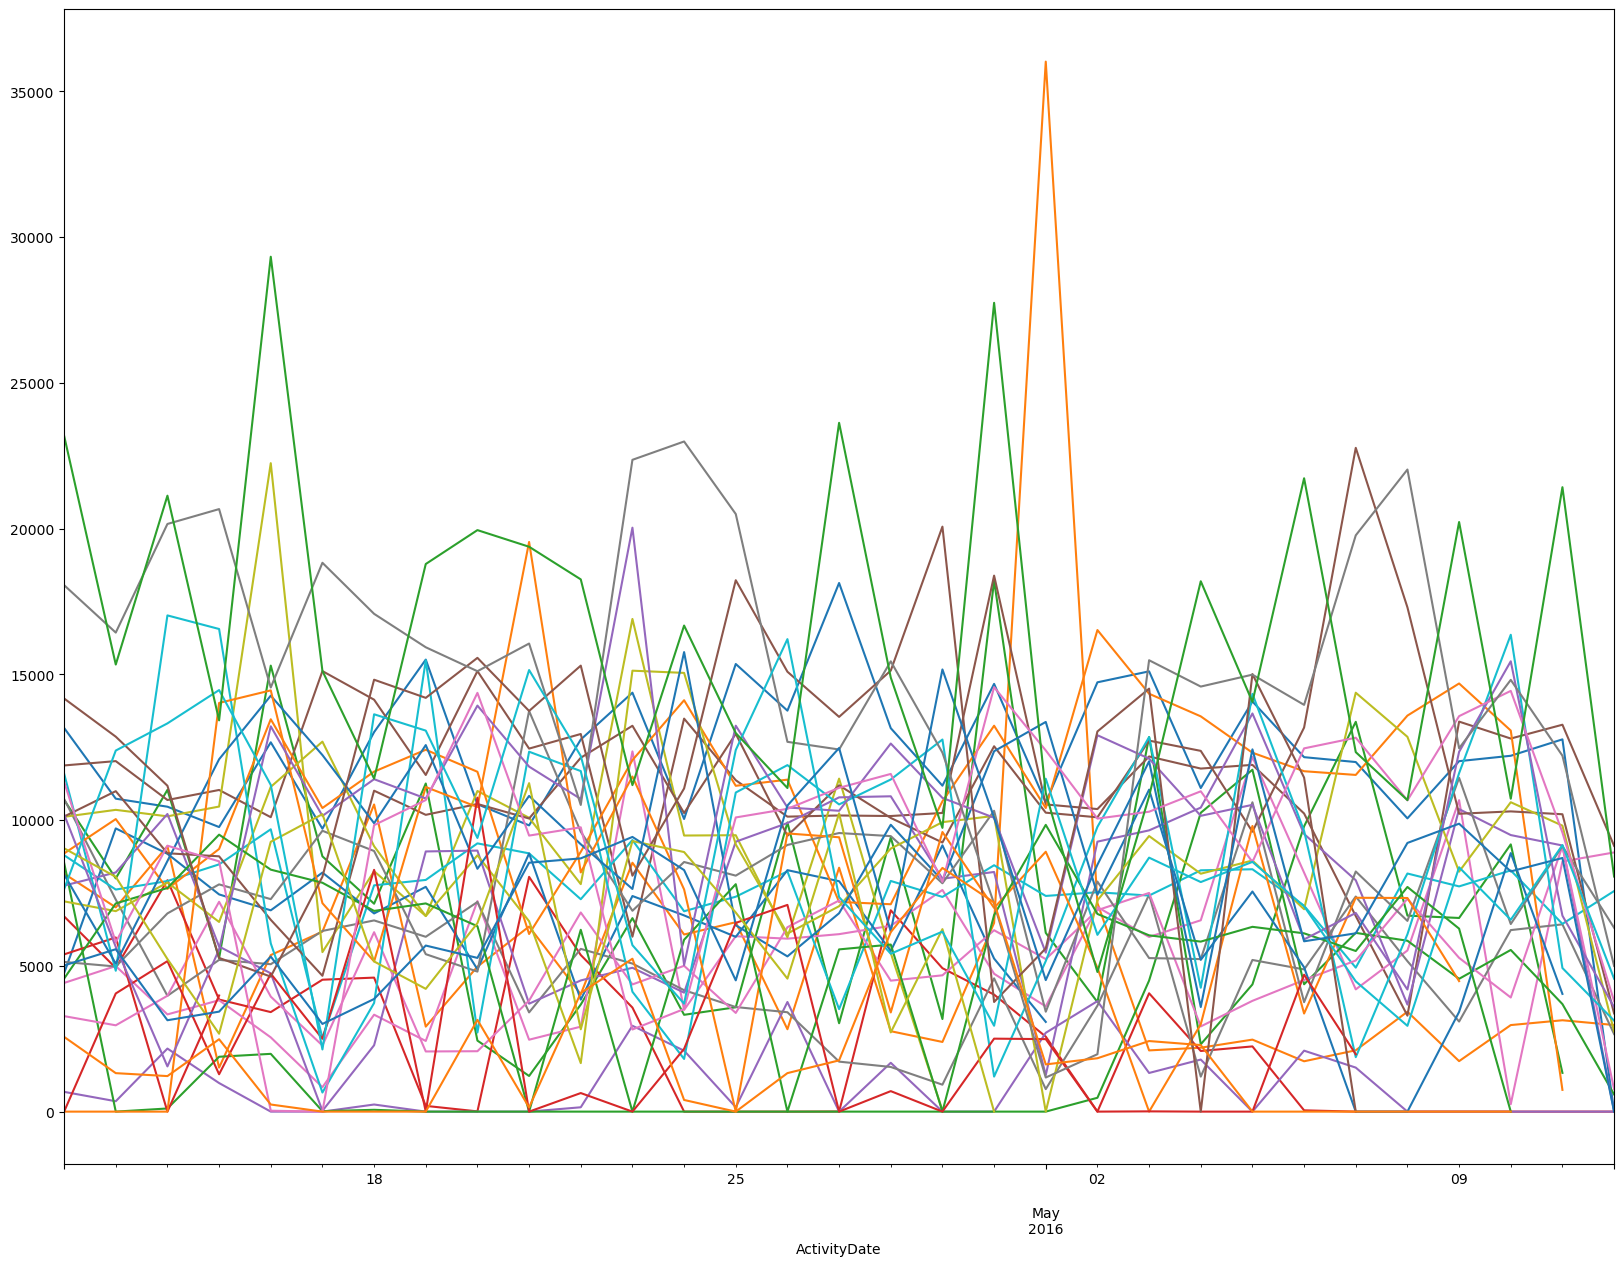

In [56]:
# Started with a quick overall plot to see if there was some sign of a general trend, there doesn't appear to be

timeline_df = daily_df.pivot(columns='Id', values='TotalSteps', index='ActivityDate')
_ = timeline_df.plot(figsize=(20,15), legend=False)

In [57]:
# Looking at the correlation between date and total steps, total distance and calories
# There is no significant correlation

corr_df = daily_df[['ActivityDate', 'TotalSteps', 'TotalDistance', 'Calories']]
corr_df.corr(numeric_only=False).style.background_gradient(cmap="Blues")

,ActivityDate,TotalSteps,TotalDistance,Calories
ActivityDate,1.000000,-0.043931,-0.040169,-0.092843
TotalSteps,-0.043931,1.000000,0.985369,0.591568
TotalDistance,-0.040169,0.985369,1.000000,0.644962
Calories,-0.092843,0.591568,0.644962,1.000000


The date does not have a significant correlation with steps, distance or calories. 

## Sleep Log Analysis

In [58]:
sleep_log.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,1,327,346
1,1503960366,2016-04-13,2,384,407
2,1503960366,2016-04-15,1,412,442
3,1503960366,2016-04-16,2,340,367
4,1503960366,2016-04-17,1,700,712


In [59]:
# Number of users with a sleep log record

sleep_users

24

Of the 33 people in the study, 24 used their tracker to record their sleep at least once.

In [60]:
# Evaluate the consistency of users logging their sleep

sleep_count = sleep_log[['Id','SleepDay']].groupby('Id').count() # Count of records per user

sleep_count['Percent'] = round(sleep_count['SleepDay']/days * 100,2) # Percent of times the user logged their sleep over the total number of days

user_sleep_count = pd.DataFrame(data=(sleep_count['Percent'].value_counts(bins=[0,25,50,75,100], sort=False)))

user_sleep_count.rename(columns={'Percent': 'User_Count'}, inplace=True)

user_sleep_count['%_of_Total_Users'] = round((user_sleep_count['User_Count']/sleep_users) * 100,1)

user_sleep_count

,User_Count,%_of_Total_Users
"(-0.001, 25.0]",8,33.3
"(25.0, 50.0]",3,12.5
"(50.0, 75.0]",2,8.3
"(75.0, 100.0]",11,45.8


In [61]:
# Count of users getting their recommended 8 hours of sleep on average

avg_sleep = sleep_log[['Id', 'TotalMinutesAsleep']].groupby('Id').mean()

sleep_8_hrs = pd.DataFrame(data={'User_Count': [len(avg_sleep[avg_sleep['TotalMinutesAsleep'] < 480]), len(avg_sleep[avg_sleep['TotalMinutesAsleep'] >= 480])], 'MinAsleep': ['<480', '480+'], '%_Total_Users': [round((len(avg_sleep[avg_sleep['TotalMinutesAsleep'] < 480])/sleep_users)*100), round((len(avg_sleep[avg_sleep['TotalMinutesAsleep'] >= 480])/sleep_users)*100)]})

sleep_8_hrs.set_index('MinAsleep')

,User_Count,%_Total_Users
MinAsleep,,
<480,22,92
480+,2,8


In [62]:
# Further breakdown of the users sleeping less than the recommended 8 hours on average

lt_8_hrs = avg_sleep[avg_sleep['TotalMinutesAsleep'] < 480]

lt_8_hrs_cnt = pd.DataFrame(data=(lt_8_hrs['TotalMinutesAsleep'].value_counts(bins=[lt_8_hrs['TotalMinutesAsleep'].min(),120,240,360,480], sort=False)))

lt_8_hrs_cnt.rename(columns={'TotalMinutesAsleep': 'User_Count'}, inplace=True)

lt_8_hrs_cnt['%_of_Total_Users'] = round((lt_8_hrs_cnt['User_Count']/sleep_users) * 100,1)

lt_8_hrs_cnt

,User_Count,%_of_Total_Users
"(60.999, 120.0]",2,8.3
"(120.0, 240.0]",1,4.2
"(240.0, 360.0]",5,20.8
"(360.0, 480.0]",14,58.3


## Weight Log Analysis

In [63]:
weight_log.head()

,Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
0,1503960366,2016-05-02,52.599998,115.963147,22.650000,True,1462233599000
1,1503960366,2016-05-03,52.599998,115.963147,22.650000,True,1462319999000
2,1927972279,2016-04-13,133.500000,294.317120,47.540001,False,1460509732000
3,2873212765,2016-04-21,56.700001,125.002104,21.450001,True,1461283199000
4,2873212765,2016-05-12,57.299999,126.324875,21.690001,True,1463097599000


In [64]:
# Number of users with a weight log record

weight_users

8

Of 33 people enrolled in this study, only 8 used their tracker to record their weight at least once.

In [65]:
# Evaluate the consistency of users logging their weight

weight_count = weight_log[['Id','Date']].groupby('Id').count() # Count of records per user

user_weight_count = pd.DataFrame(data=(weight_count['Date'].value_counts()))

user_weight_count.rename(columns={'Date': 'User_Count'}, inplace=True)

user_weight_count['%_of_Total_Users'] = round((user_weight_count['User_Count']/weight_users) * 100,1)

user_weight_count

,User_Count,%_of_Total_Users
2,3,37.5
1,2,25.0
5,1,12.5
30,1,12.5
24,1,12.5


In [66]:
# I am only interested in users that recorded their weight more than once, so I can observe any trends

weight_log['dups'] = weight_log['Id'].duplicated(keep=False) # Mark all dups as "True" so they can be kept

weight_log_trends = weight_log.query('dups == True') # Query to grab all dups

weight_log_trends['Id'].nunique()

6

Of those 8, only 6 recorded their weight at least twice. <br>
We know from the original examination that none of the users recorded their weight everyday.

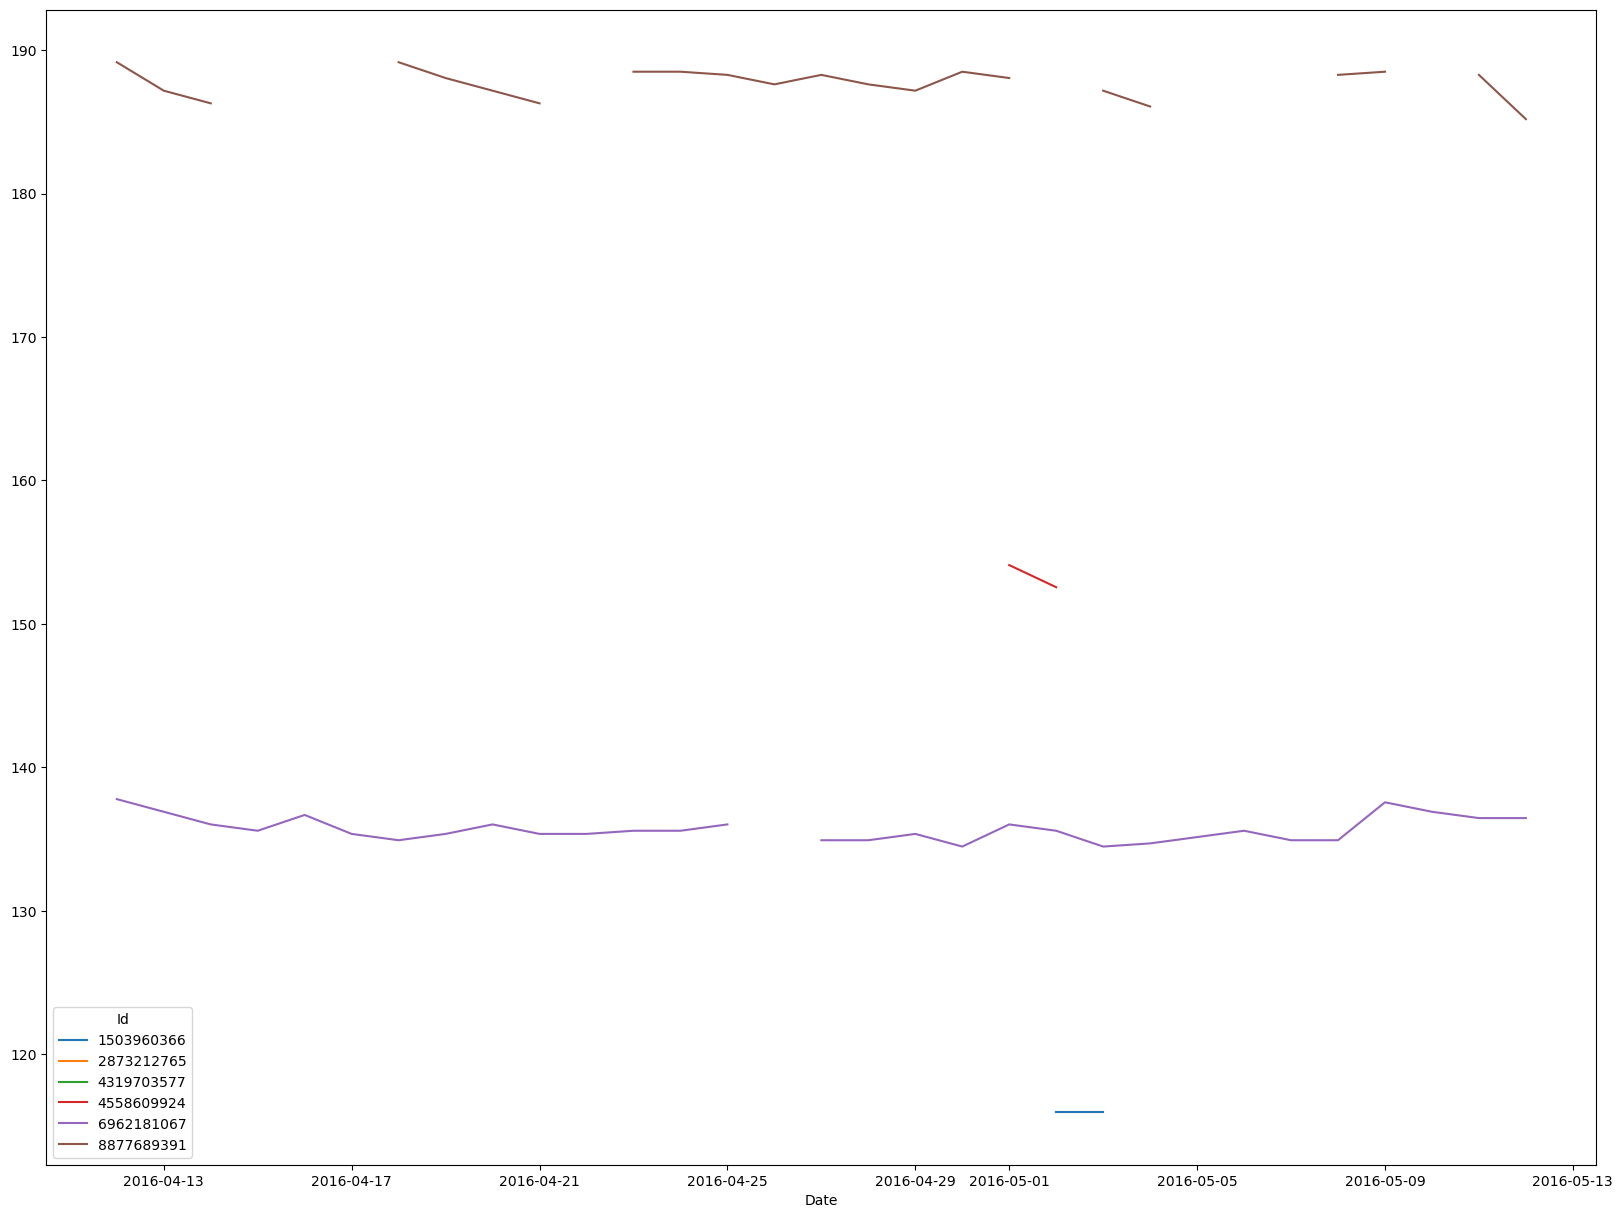

In [67]:
# Pivot the df so that the dates are the index and Ids are the fields

weight_tl = weight_log_trends.pivot(columns='Id', values='WeightPounds', index='Date')

# Plot weight over the dates
# Non-consecutive weights won't appear in the graph

_ = weight_tl.plot(figsize=(20,15))

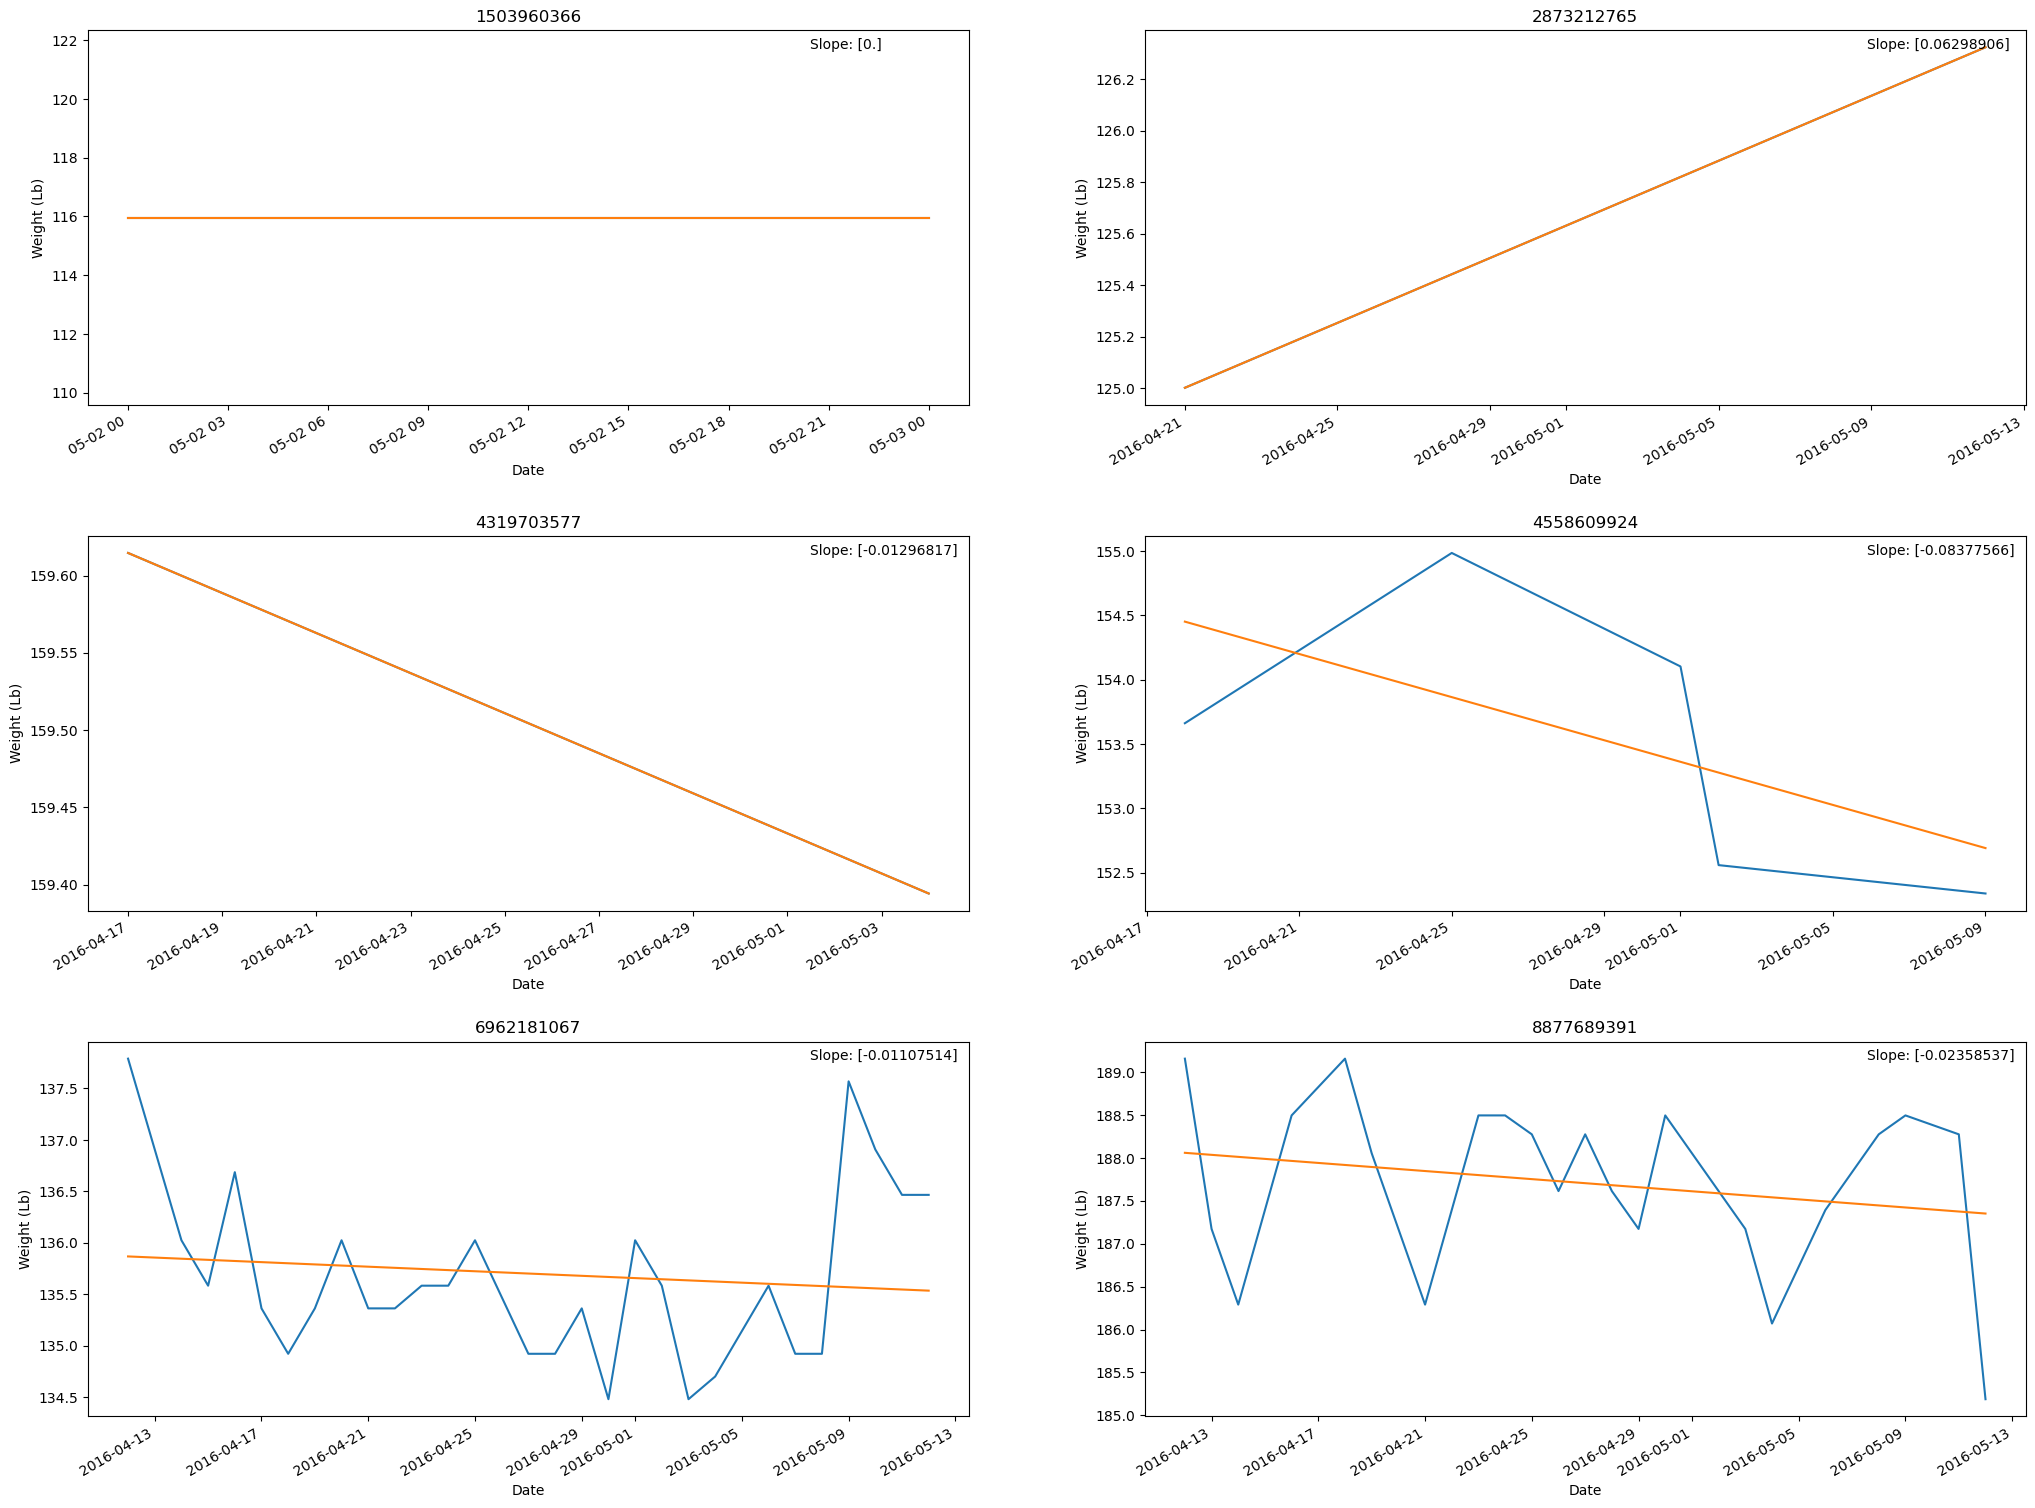

In [68]:
# I want to visualize (and quantify) the weight change of users and look for a relationship between weight and exercise
# I will do this with LinearRegression

weight_tl['time'] = np.arange(len(weight_tl.index)) # Add time field

weight_change = pd.DataFrame() # Create new df for storing the slope, weight change, number of days between first weight and last weight, average steps, and average calories
weight_change.index = ['trendline slope', 'weight diff (Lb)', 'date diff', 'avg steps', 'avg calories']

fig, axes = plt.subplots(3,2) # Set up subplots for each user
plt.subplots_adjust(hspace=0.35)

a, b = 0, 0 # variable for the axes of each graph

for i in range(0,6):
    weight_tl_ = weight_tl_ = weight_tl.loc[:,[weight_tl.columns.values[i],'time']].dropna() # remove NAs for the current column

    X = weight_tl_.loc[:,['time']] 
    y = weight_tl_.loc[:,weight_tl.columns.values[i]]

    model = LinearRegression()
    model.fit(X,y)

    y_pred = pd.Series(model.predict(X), index=X.index)

    ax = y.plot(figsize=(25,18), ylabel="Weight (Lb)", title=weight_tl.columns.values[i], ax=axes[a][b]) # Plot current column values 
    ax = y_pred.plot(ax=ax, linewidth=1.5) # Plot trendline
    txt = "Slope: " + str(model.coef_) # Slope text
    plt.text(x=0.82,y=0.95,s=txt,transform=ax.transAxes) # Add the slopes to the graphs
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    b += 1
    
    if b % 2 == 0:
        a += 1
        b = 0
    
    # Insert data into the new df created above
    weight_change[weight_tl.columns.values[i]] = [str(model.coef_), (weight_tl_.iloc[-1][weight_tl.columns.values[i]] - weight_tl_.iloc[0][weight_tl.columns.values[i]]), (weight_tl_.iloc[-1]['time'] - weight_tl_.iloc[0]['time']), round(avg_steps_cals['TotalSteps'].loc[avg_steps_cals.index == weight_tl.columns.values[i]].values[0]), round(avg_steps_cals['Calories'].loc[avg_steps_cals.index == weight_tl.columns.values[i]].values[0])]

In [69]:
weight_change

,1503960366,2873212765,4319703577,4558609924,6962181067,8877689391
trendline slope,[0.],[0.06298906],[-0.01296817],[-0.08377566],[-0.01107514],[-0.02358537]
weight diff (Lb),0.0,1.32277,-0.220459,-1.32277,-1.32277,-3.968327
date diff,1.0,21.0,17.0,21.0,30.0,30.0
avg steps,12117,7556,7269,7685,9795,16040
avg calories,1816,1917,2038,2033,1982,3420


## Relationships
Now, I will examine the relationships between the datasets and between columns of the same dataset. 

### Activity and Sleep
Focussing on active minutes, total steps, calories, total distance.

In [70]:
# Adding a new field called "Active Minutes" which is a sum of very active and fairly active minutes

dailies = daily_df.copy()

dailies['ActiveMin'] = dailies['VeryActiveMinutes'] + dailies['FairlyActiveMinutes']

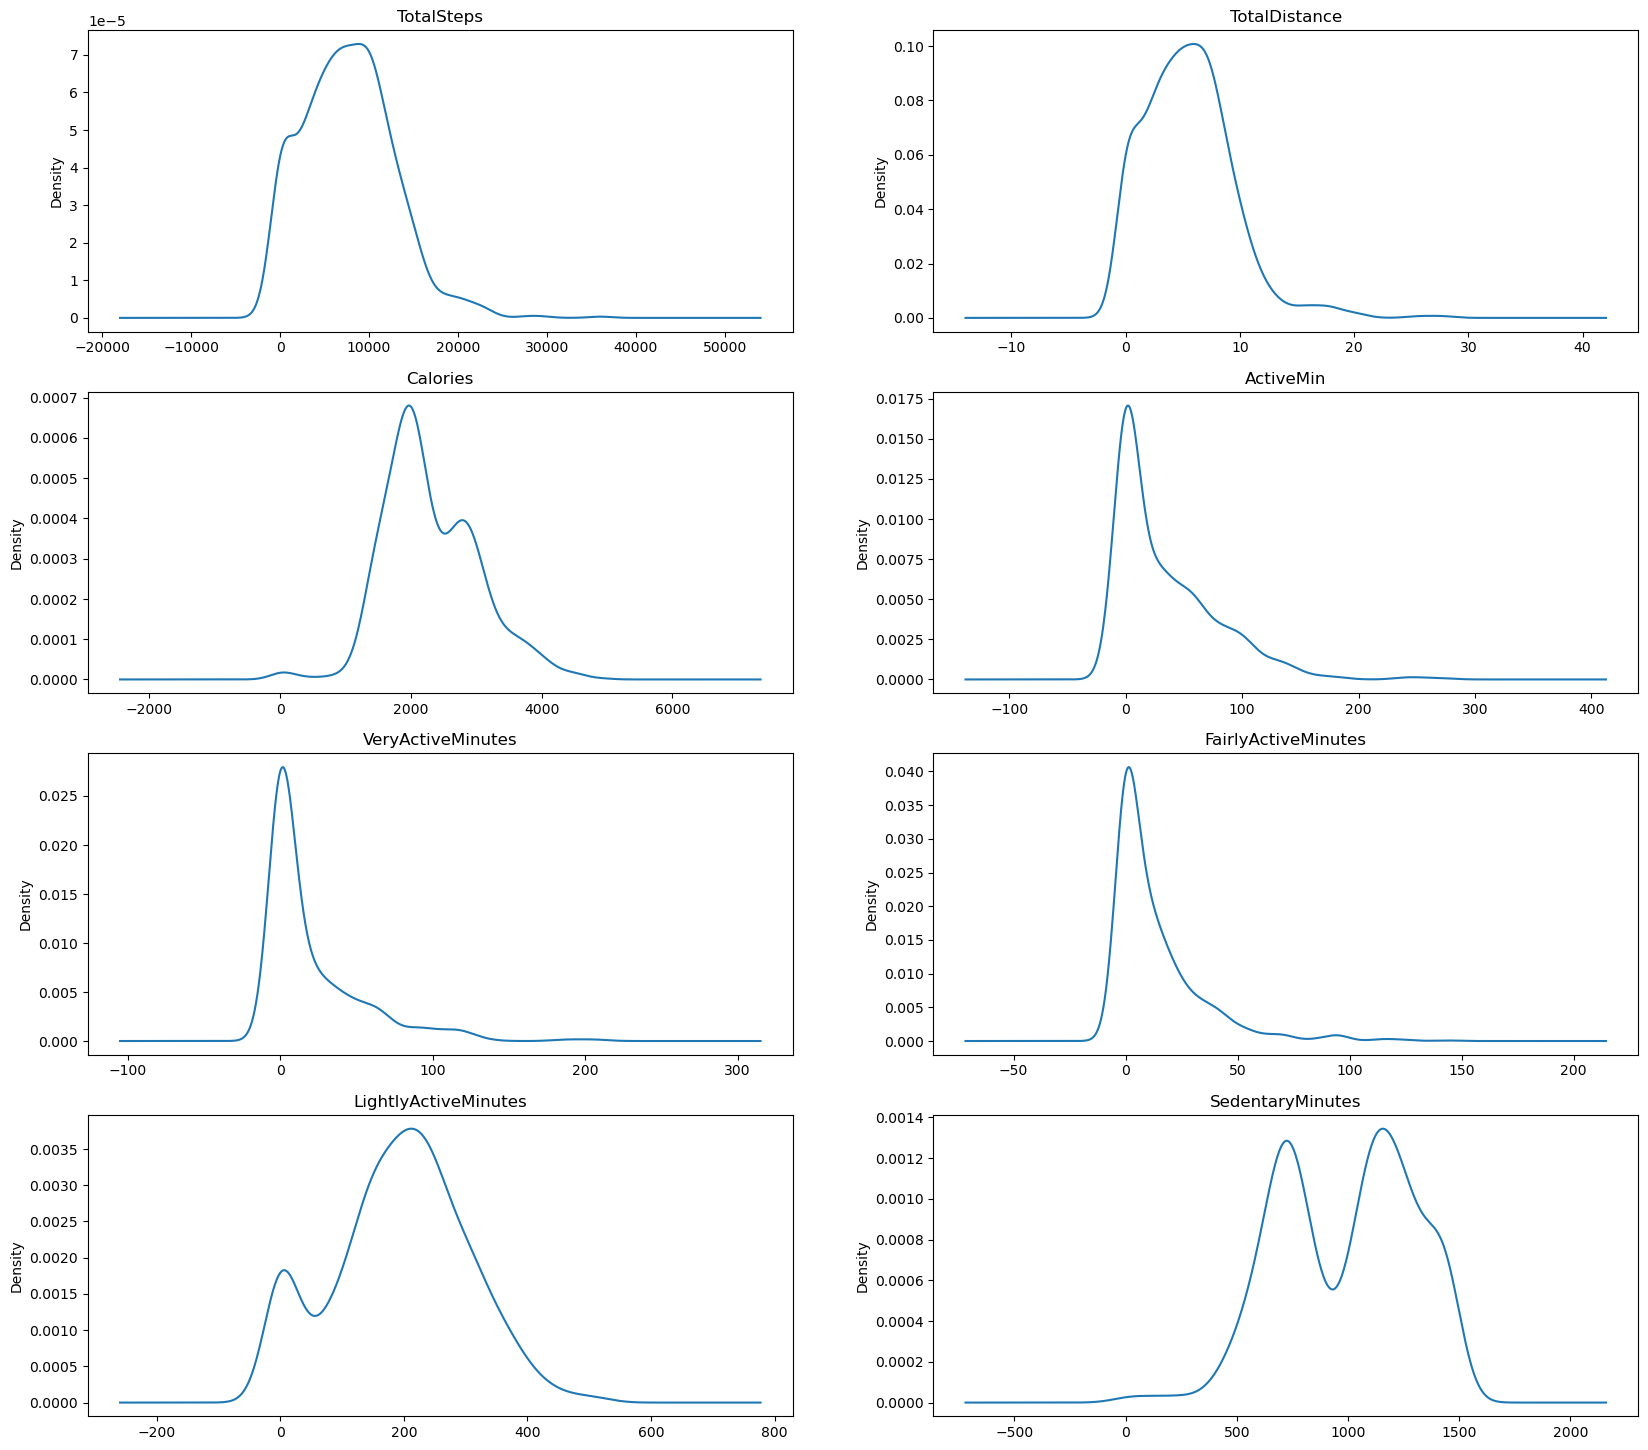

In [71]:
# Evaluating the distribution of each field to determine which correlation coefficient to use

fig, axes = plt.subplots(4,2) # Set up subplots for each minute column
plt.subplots_adjust(hspace=0.2)

a, b = 0, 0 # variable for the axes of each graph

for i in np.concatenate((['TotalSteps'], ['TotalDistance'], ['Calories'], ['ActiveMin'], minutes)):
    _ = dailies[i].plot(kind='kde', title=i, figsize=(20,18), ax=axes[a][b])
    
    b += 1
    
    if b % 2 == 0:
        a += 1
        b = 0

Some plots are non-normal, so I will include the Kendall correlation coefficient in the correlation calculations for those fields.

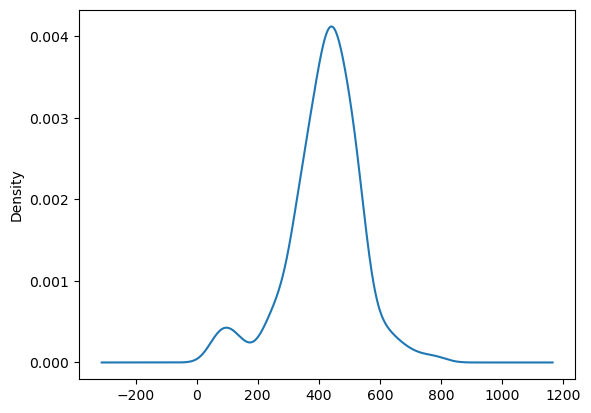

In [72]:
# Sleep time distribution

_ = sleep_log['TotalMinutesAsleep'].plot(kind='kde')

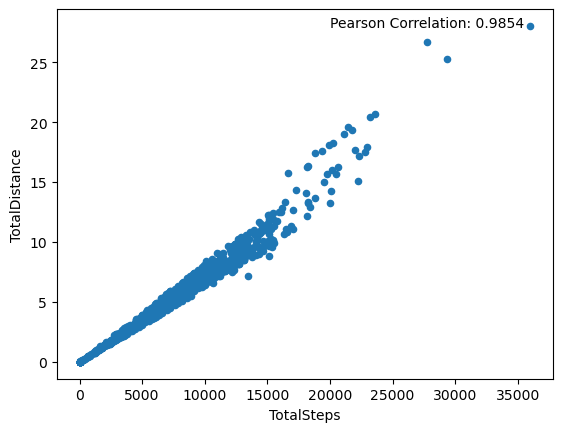

In [73]:
# A look at very strong correlation: distance vs steps

ax = dailies.plot.scatter(x='TotalSteps', y='TotalDistance')
txt = 'Pearson Correlation: ' + str(round(dailies[['TotalSteps', 'TotalDistance']].corr()['TotalDistance'][0],4))
_ = ax.text(x=0.55,y=0.95,s=txt,transform=ax.transAxes)

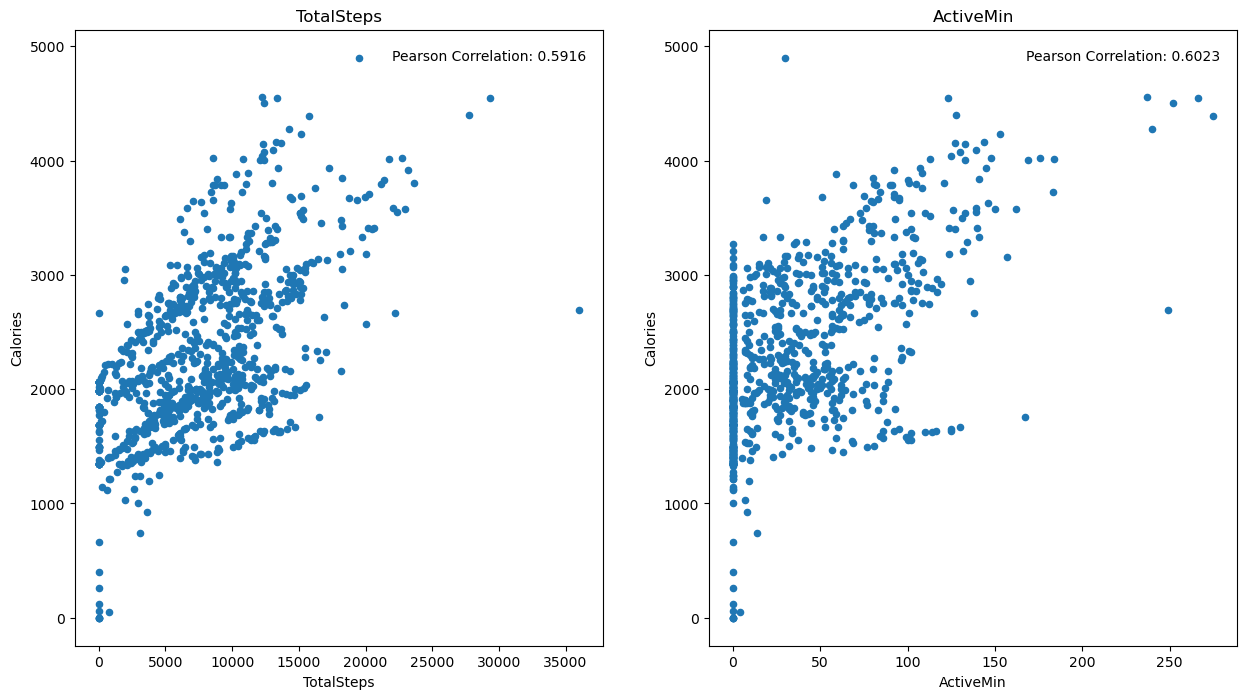

In [74]:
# Strong correlation: calories vs total steps or calories vs active minutes

fig, axes = plt.subplots(1,2) # Set up subplots for each minute column
plt.subplots_adjust(hspace=0.2)

a = 0 # variable for the axes of each graph

for i in ['TotalSteps', 'ActiveMin']:
    ax = dailies.plot.scatter(x=i, y='Calories', title=i, figsize=(15,8), ax=axes[a])
    txt = 'Pearson Correlation: ' + str(round(dailies[[i, 'Calories']].corr()['Calories'][0],4))
    _ = ax.text(x=0.60,y=0.95,s=txt,transform=ax.transAxes)
    
    a += 1

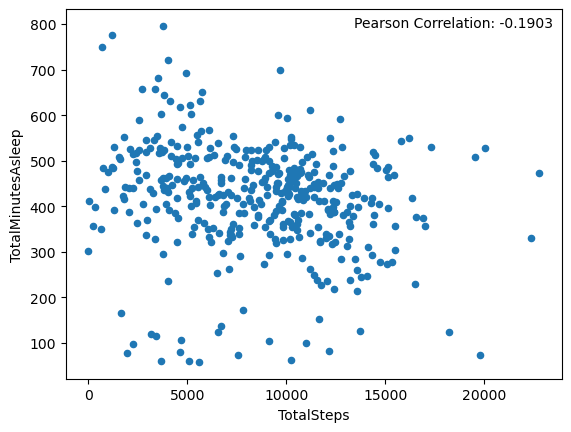

In [75]:
# Merge the datasets on ID and Date and plot sleep time vs total steps

activity = dailies.rename(columns={'ActivityDate': 'Date'}) # Make a copy of daily_df with renamed date column
sleep = sleep_log.copy().rename(columns={'SleepDay': 'Date'}) # Make a copy of sleep_log with renamed date column

active_sleep = pd.merge(activity, sleep, on=['Id', 'Date'], how='inner')

ax = active_sleep.plot.scatter(y='TotalMinutesAsleep', x='TotalSteps')
txt = 'Pearson Correlation: ' + str(round(active_sleep[['TotalSteps', 'TotalMinutesAsleep']].corr()['TotalMinutesAsleep'][0],4))
_ = ax.text(x=0.58,y=0.95,s=txt,transform=ax.transAxes)

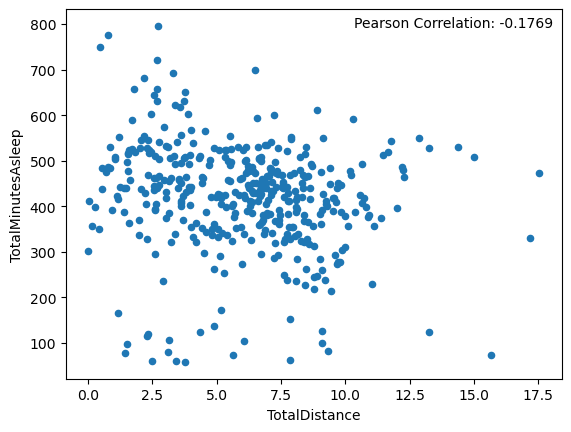

In [76]:
# Correlation between sleep and total distance

ax = active_sleep.plot.scatter(y='TotalMinutesAsleep', x='TotalDistance')
txt = 'Pearson Correlation: ' + str(round(active_sleep[['TotalMinutesAsleep', 'TotalDistance']].corr()['TotalDistance'][0],4))
_ = ax.text(x=0.58,y=0.95,s=txt,transform=ax.transAxes)

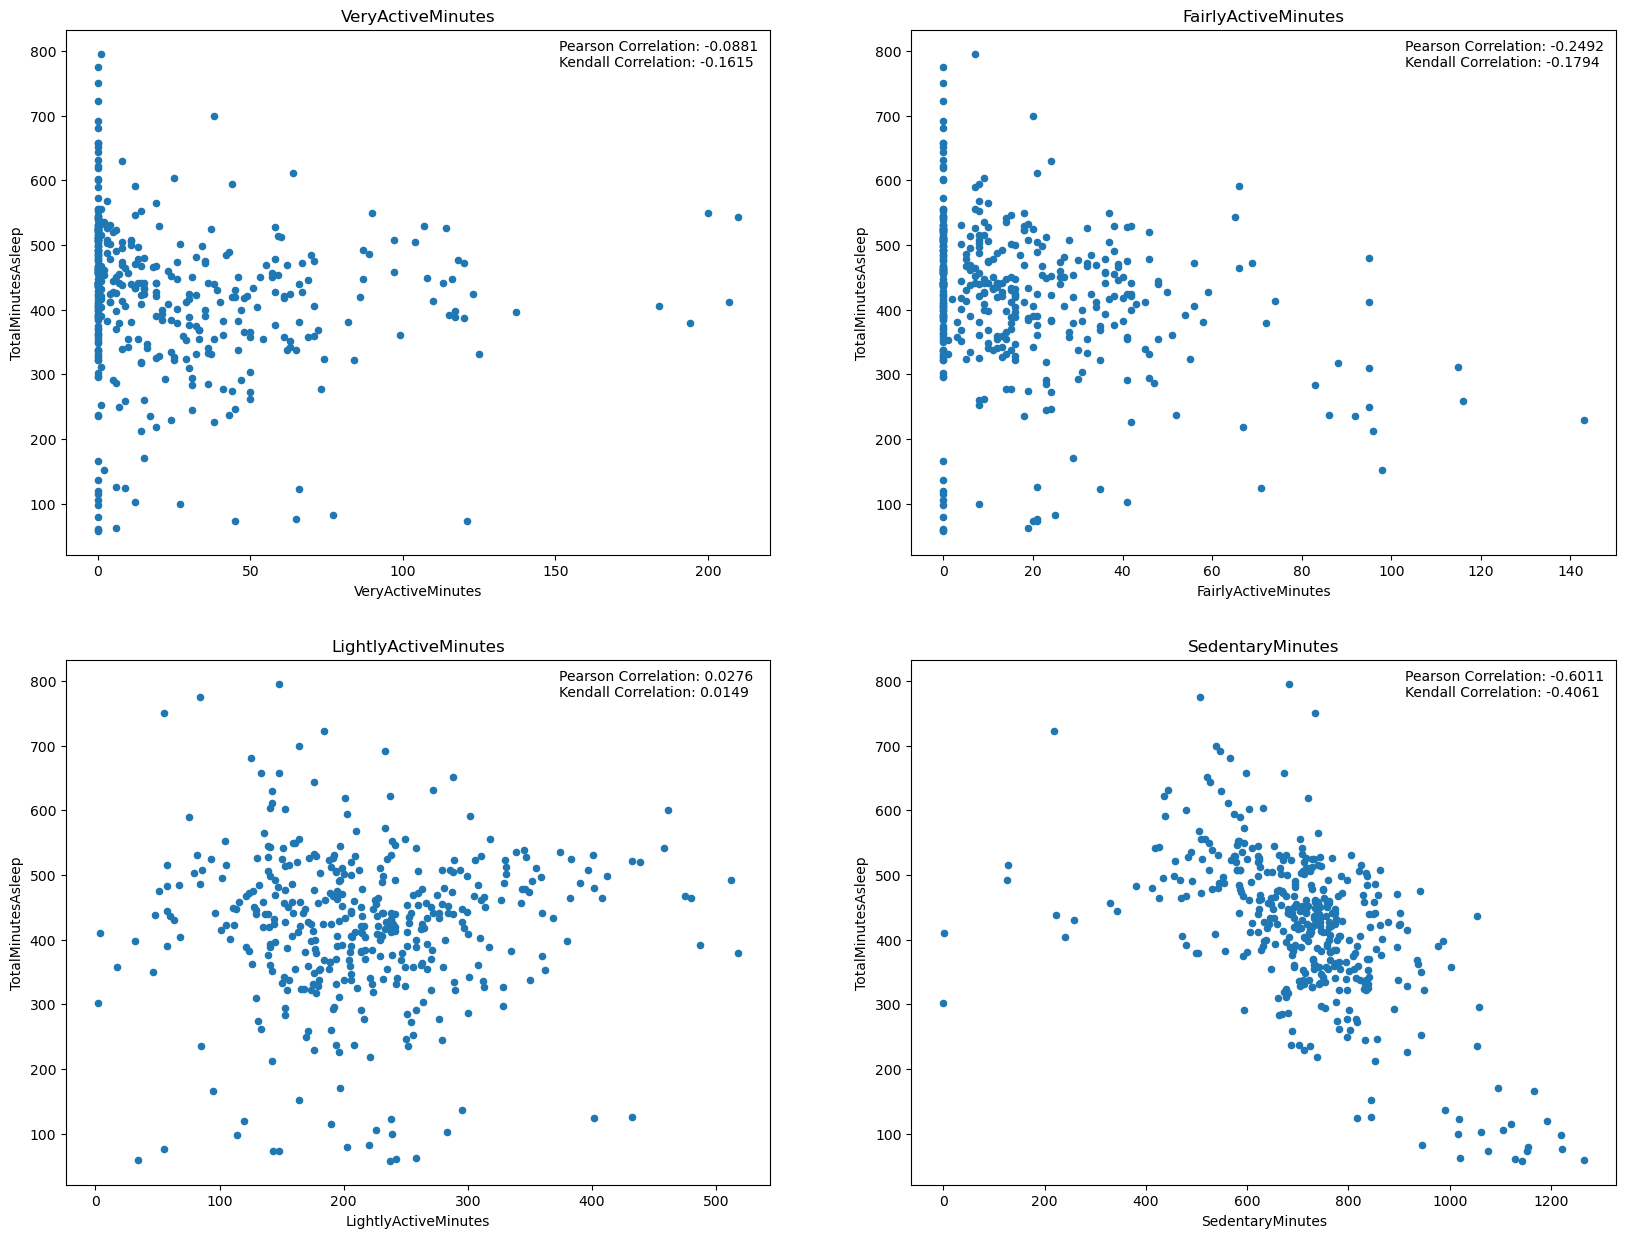

In [77]:
# activity levels vs total minutes asleep

fig, axes = plt.subplots(2,2) # Set up subplots for each minute column
plt.subplots_adjust(hspace=0.2)

a, b = 0, 0 # variable for the axes of each graph

for i in minutes: # minutes is an array of the minute column names that was created when looking for outliers in the dataset
    ax = active_sleep.plot.scatter(x=i, y='TotalMinutesAsleep', title=i, figsize=(20,15), ax=axes[a][b])
    txt = 'Pearson Correlation: ' + str(round(active_sleep[[i, 'TotalMinutesAsleep']].corr()['TotalMinutesAsleep'][0],4)) + '\nKendall Correlation: ' + str(round(active_sleep[[i, 'TotalMinutesAsleep']].corr(method='kendall')['TotalMinutesAsleep'][0],4))
    _ = ax.text(x=0.70,y=0.93,s=txt,transform=ax.transAxes)
    
    b += 1
    
    if b % 2 == 0:
        a += 1
        b = 0

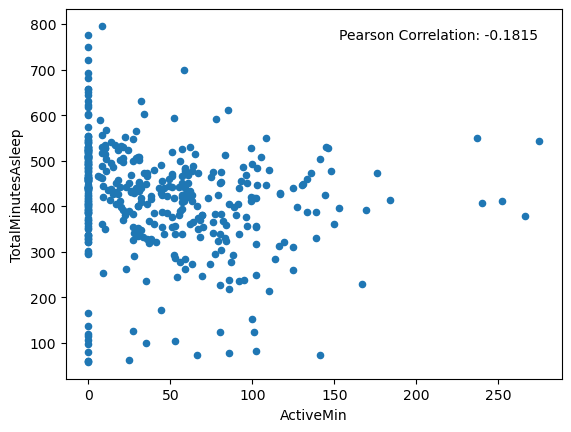

In [78]:
# Sleep time vs active min

ax = active_sleep.plot.scatter(x='ActiveMin', y='TotalMinutesAsleep')
txt = 'Pearson Correlation: ' + str(round(active_sleep[['ActiveMin', 'TotalMinutesAsleep']].corr(numeric_only=False)['TotalMinutesAsleep'][0],4))
_ = ax.text(x=0.55,y=0.92,s=txt,transform=ax.transAxes)

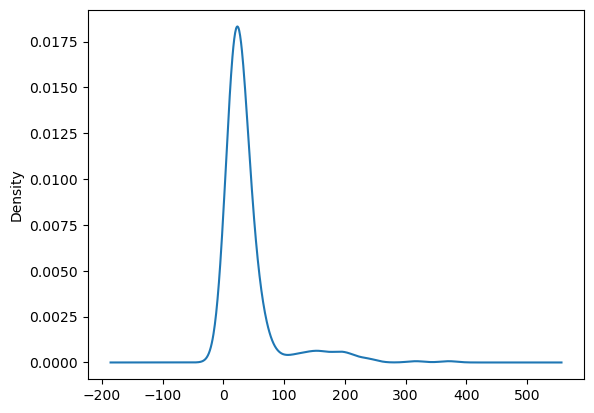

In [79]:
# Create a new column called excess time in bed, the difference between time asleep and time in bed

active_sleep['ExcessTimeInBed'] = active_sleep['TotalTimeInBed'] -active_sleep['TotalMinutesAsleep']

_ = active_sleep['ExcessTimeInBed'].plot(kind='kde')

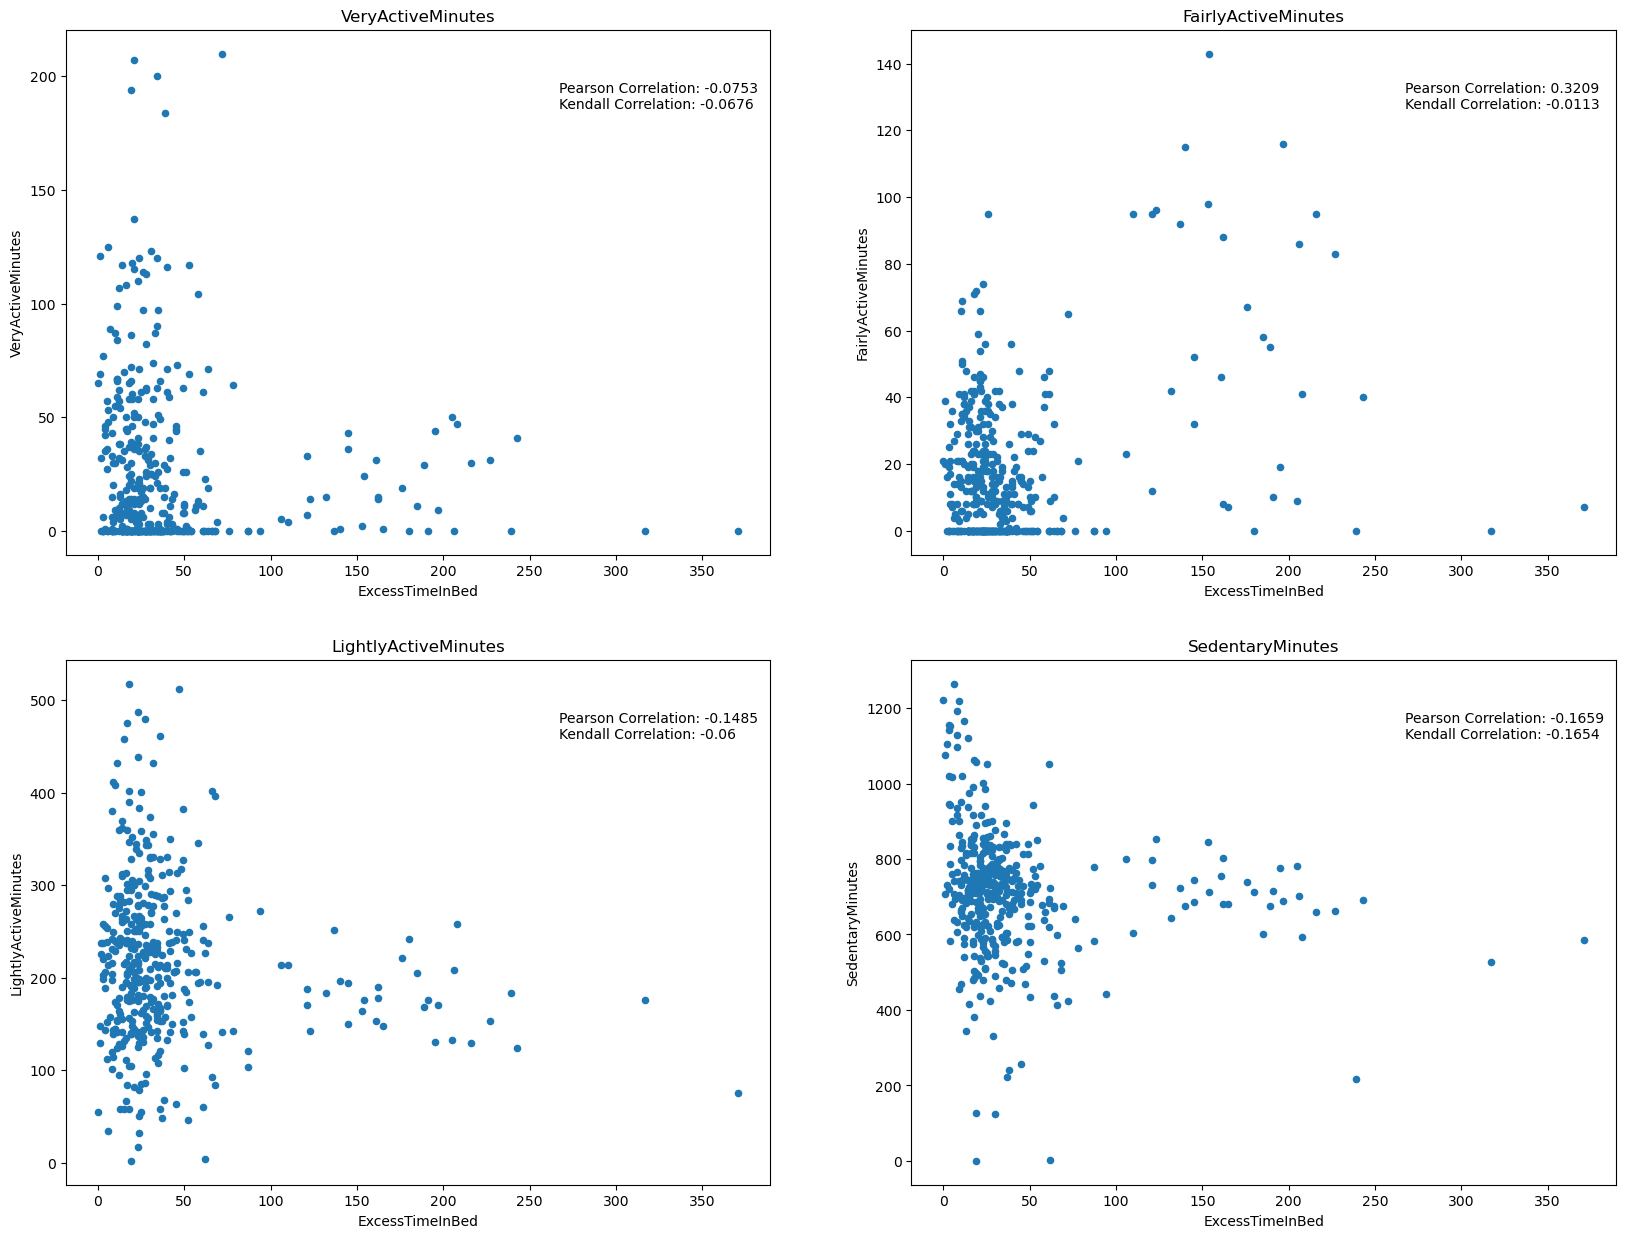

In [80]:
# activity levels vs excess time in bed

fig, axes = plt.subplots(2,2) # Set up subplots for each column
plt.subplots_adjust(hspace=0.2)

a, b = 0, 0 # variable for the axes of each graph

for i in minutes:
    ax = active_sleep.plot.scatter(x='ExcessTimeInBed', y=i, title=i, figsize=(20,15), ax=axes[a][b])
    txt = 'Pearson Correlation: ' + str(round(active_sleep[[i, 'ExcessTimeInBed']].corr(numeric_only=False)['ExcessTimeInBed'][0],4)) + '\nKendall Correlation: ' + str(round(active_sleep[[i, 'ExcessTimeInBed']].corr(method='kendall')['ExcessTimeInBed'][0],4))
    _ = ax.text(x=0.70,y=0.85,s=txt,transform=ax.transAxes)
    
    b += 1
    
    if b % 2 == 0:
        a += 1
        b = 0

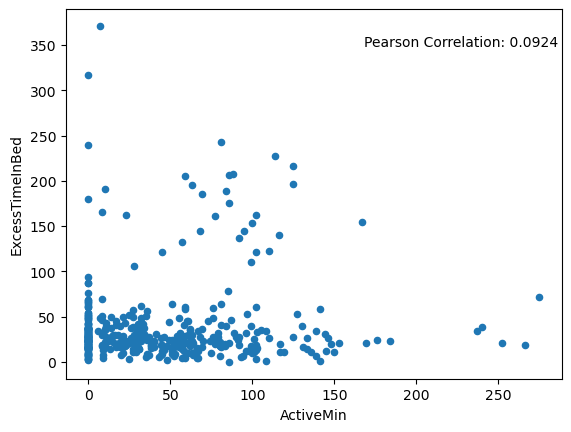

In [81]:
# Excess time in bed vs Active Min

ax = active_sleep.plot.scatter(x='ActiveMin', y='ExcessTimeInBed')
txt = 'Pearson Correlation: ' + str(round(active_sleep[['ActiveMin', 'ExcessTimeInBed']].corr(numeric_only=False)['ExcessTimeInBed'][0],4))
_ = ax.text(x=0.60,y=0.90,s=txt,transform=ax.transAxes)

### Weight and Activity
While fairly controversial and unreliable, the BMI would be a better indicator of "health" than weight alone, so I will use BMI and evaluate the relationships between BMI and activity levels and sleep.

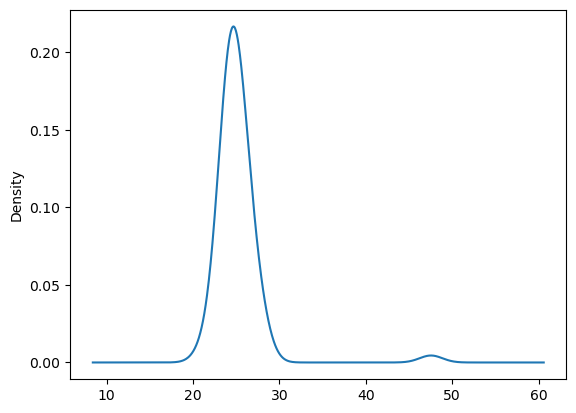

In [82]:
# Evaluating the distribution of the BMI field

_ = weight_log['BMI'].plot(kind='kde')

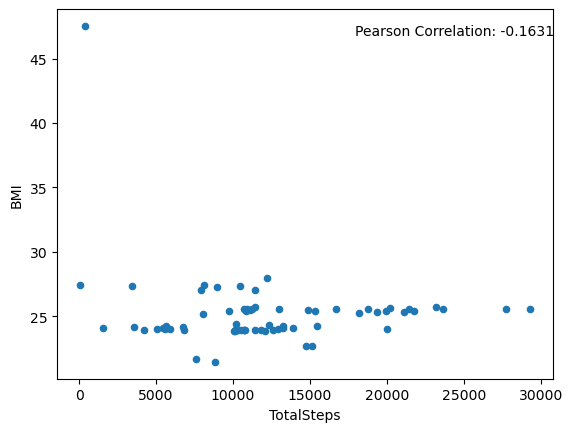

In [83]:
# Merge the datasets on ID and Date and plot BMI vs total steps
weight = weight_log.copy() # Make a copy of weight log
weight['Date'] = pd.to_datetime(weight['Date']) # Change the date to datetime

active_weight = pd.merge(activity, weight, on=['Id', 'Date'], how='inner')

ax = active_weight.plot.scatter(x='TotalSteps', y='BMI')
txt = 'Pearson Correlation: ' + str(round(active_weight[['TotalSteps', 'BMI']].corr()['BMI'][0],4))
_ = ax.text(x=0.60,y=0.93,s=txt,transform=ax.transAxes)

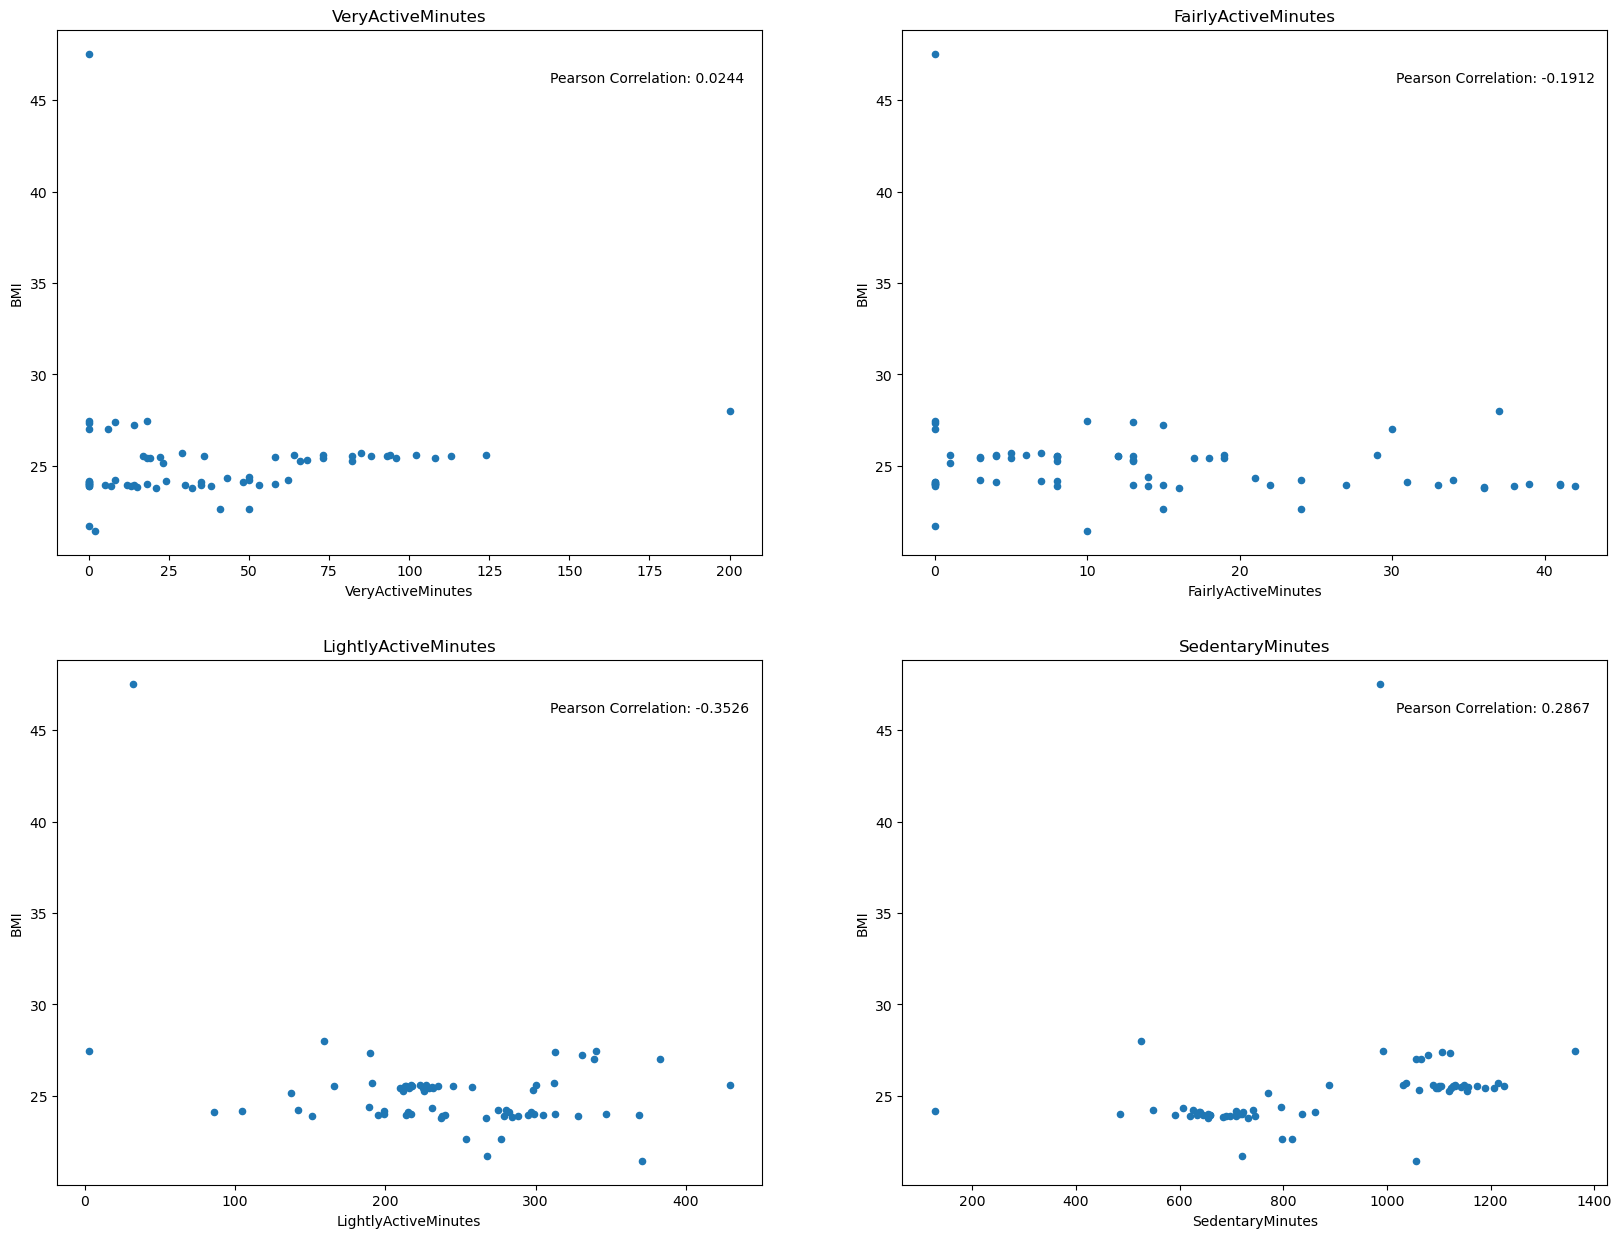

In [84]:
# Activity levels vs BMI

fig, axes = plt.subplots(2,2) # Set up subplots for each column
plt.subplots_adjust(hspace=0.2)

a, b = 0, 0 # variable for the axes of each graph

for i in minutes:
    ax = active_weight.plot.scatter(x=i, y='BMI', title=i, figsize=(20,15), ax=axes[a][b])
    txt = 'Pearson Correlation: ' + str(round(active_weight[[i, 'BMI']].corr()['BMI'][0],4))
    _ = ax.text(x=0.70,y=0.90,s=txt,transform=ax.transAxes)
    
    b += 1
    
    if b % 2 == 0:
        a += 1
        b = 0

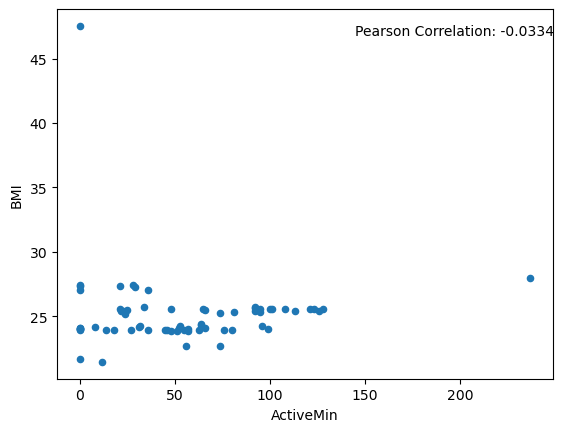

In [85]:
# Active Min vs BMI

ax = active_weight.plot.scatter(x='ActiveMin', y='BMI')
txt = 'Pearson Correlation: ' + str(round(active_weight[['ActiveMin', 'BMI']].corr()['BMI'][0],4))
_ = ax.text(x=0.60,y=0.93,s=txt,transform=ax.transAxes)

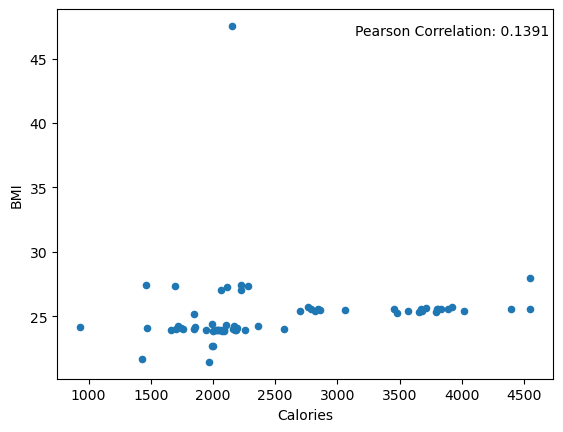

In [86]:
ax = active_weight.plot.scatter(x='Calories', y='BMI')
txt = 'Pearson Correlation: ' + str(round(active_weight[['BMI', 'Calories']].corr()['Calories'][0],4))
_ = ax.text(x=0.60,y=0.93,s=txt,transform=ax.transAxes)

### Weight and Sleep

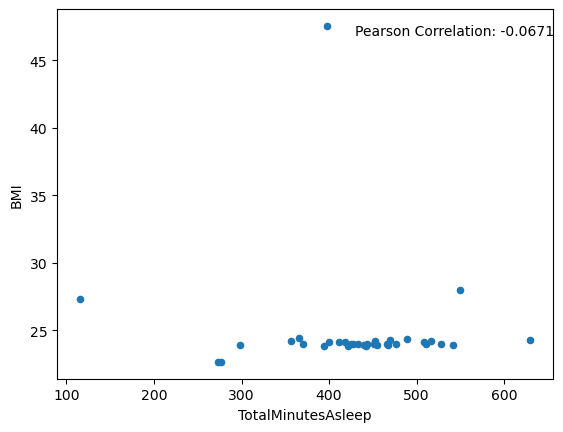

In [87]:
sleep_weight = pd.merge(sleep, weight, on=['Id', 'Date'], how='inner')

ax = sleep_weight.plot.scatter(x='TotalMinutesAsleep', y='BMI')
txt = 'Pearson Correlation: ' + str(round(sleep_weight[['TotalMinutesAsleep', 'BMI']].corr()['BMI'][0],4))
_ = ax.text(x=0.60,y=0.93,s=txt,transform=ax.transAxes)

# Supplemental Study Data

I wanted to find a dataset that would either provide usage data for more users over a longer period of time or would provide opinion-based data from users regarding their experience with smart fitness devices. <br>
I found [this study](https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-017-4888-1) which does the latter. <br>
They surveyed 200 current fitness tracker users and 37 ex-users, looking for information about users' complaints about their trackers, which features they found useful, the main motivation for wearing the tracker and more. <br>
As I don't have access to the raw data, my intention is to use the findings from the study to provide additional insight and a new perspective.

# Summary of Analysis and Insights

The most interesting finding from the data, for me, was that the users' lifestyles are moderately active. The majority of users are not meeting the daily step or activity goals but since they are consistently using their fitness trackers, we can expect that they have a desire to be mindful of their health and habits. This is beneficial for Bellabeat as it is focused on wellness rather than physical fitness alone. <br>
The weight logging feature was not used by the majority of the users and was not used very frequently. Weight loss does not appear to be a focus for most of the users. <br>
The sleep logging feature was used by the majority of users, but the frequency was somewhat low. An overwhelming majority are not getting their 8 hours of sleep and given the strong relationship between sleep and sedentary minutes, the reduced time asleep leads to less energy to be active. Or, conversely, the lower activity levels are leading to worse sleep. As neither variable is independent, this goes both ways and can be marketed in whichever way is most effective. <br>
<br>
The findings from the supplemental study show that the top 3 most useful features were steps, active minutes, and sleep. Though only a minority reported changing their sleeping habits. <br>
The top motivation for participants in the study to wear their trackers was to monitor activities. This beat out improving fitness which indicates that users are interested in more than just fitness, they want to keep track of habits and build a healthy lifestyle. <br>
Two of the leading complaints for participants in the study regarding their trackers are that the battery life is not long enough and that the tracker does not go with their outfits. Bellabeat has both of these problems solved, the 6-month battery life and ability to switch out the battery avoids those issues altogether. The Time's appearance is also unlike other trackers, it looks like a regular watch that would go well with any outfit. <br>
I have put my high-level insights and visualizations into a Tableau dashboardwhich can be found on Tableau Public, link below: <br>
https://public.tableau.com/views/CaseStudy_16897032981500/Dashboard13?:language=en-US&:display_count=n&:origin=viz_share_link

# Sources

[1] Centers for Disease Control and Prevention. (n.d.). How much physical activity do adults need?. https://www.cdc.gov/physicalactivity/basics/adults/index.htm#:~:text=We%20know%20150%20minutes%20of,See%20tips%20for%20getting%20started

[2] Furberg, R., Brinton, J., Keating, M., & Ortiz, A. (2016). Crowd-sourced Fitbit datasets 03.12.2016-05.12.2016 [Data set]. Zenodo. https://doi.org/10.5281/zenodo.53894

[3] Huizen, J. (2019). How many steps should you take a day for fitness or weight loss?. Medical News Today. https://www.medicalnewstoday.com/articles/how-many-steps-should-you-take-a-day 

[4] Maher et al. BMC Public Health (2017) 17:88. DOI 10.1186/s12889-017-4888-1.

[5] user7864386. (March 1 2022). Find Max of a Group, and Return Another Column's Value. StackOverflow. https://stackoverflow.com/questions/71311300/find-max-of-a-group-and-return-another-columns-value